# Exemplo de Rastro Local
## Autor: Marcus Vinícius Borela de Castro

Ilustrar o uso de Rastro-DM em um projeto de regressão: predição do IDEB de uma escola a partir das suas características de infraestrutura. 



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings("ignore")
import seaborn as sns
import time
import pickle

In [50]:
vfigsize=(10,6)
vrandom_state = 42

# Rotinas de apoio criadas para armazenar rastro local

In [20]:
def regredir(df_avaliacao, modelo, obs, X, y, kf,  verbose = True):
    """
    Fonte versão original (evoluida aqui) do código em http://ataspinar.com/2017/05/26/classification-with-scikit-learn/ 
    """
    # dicas de métricas em https://scikit-learn.org/stable/modules/model_evaluation.html
    t_start = time.time()
    cv_results = cross_validate(modelo, X, y, cv=kf,
             scoring=('neg_mean_absolute_error','neg_median_absolute_error', 'r2'),
             return_train_score=True,
                   n_jobs=-1)
    t_end = time.time()

    t_diff = t_end - t_start
    df_avaliacao = add_df_avaliacao(df_avaliacao, obs, cv_results, modelo, kf, len(y))
    if verbose:
        print(round(t_diff,3),list(df_avaliacao.iloc[-1][["modelo","test_neg_mean_absolute_error_mean","test_neg_median_absolute_error_mean","train_neg_mean_absolute_error_mean","train_neg_median_absolute_error_mean"]]))
    return df_avaliacao


In [21]:
import itertools
def gera_parametros_classificador(classificador, parm_variacao):
    parm_lista = list(parm_variacao.items())
    lista_combinacoes=[]
    qtd=0
    totitens = len(parm_variacao)
    lista_valores = list(parm_lista[i][1] for i in range(totitens))
    lista_labels = list(parm_lista[i][0] for i in range(totitens))
    valores_permutados = list(itertools.product(*lista_valores))
    #print(valores_permutados)
    #print(lista_labels)
    parametro_clf_base = classificador.get_params(deep=True)
    for combinacao in valores_permutados:
        parametro_clf = parametro_clf_base.copy()
        #print(combinacao)
        for ind_parm in range(totitens):
            #print(lista_labels[ind_parm], combinacao[ind_parm] ) 
            parametro_clf[lista_labels[ind_parm]] = combinacao[ind_parm]
        #print(parametro_clf_base)
        lista_combinacoes.append(parametro_clf)
        qtd+=1
    print('Combinados ',totitens, ' parâmetros', ' em ', qtd, ' combinaçoes')
    return lista_combinacoes   



In [22]:
def imprime_lista_obs():
    for item in lista_obs:
        print(" "); print(item)
    return

In [23]:
def registrar_obs(parm_obs):
    global lista_obs
    lista_obs.append(parm_obs)
    return

In [24]:
def criar_lista_obs():
    global lista_obs
    lista_obs=["Lista de observações sobre a modelagem efetuada"]
    return

In [25]:
def apagar_ultimas_n_obs(qtd):
    global lista_obs
    lista_obs = lista_obs[:-qtd]
    return

In [26]:
def apagar_ultimas_n_execucoes(qtd):
    global df_avaliacao
    df_avaliacao = df_avaliacao.iloc[:-qtd]
    return

In [27]:
def regredir_lista(df_avaliacao, obs, X, y, kf, lista_modelos, verbose = True):
    if verbose:
        print("tempo", "modelo","test_neg_mean_absolute_error_mean","test_neg_median_absolute_error_mean","train_neg_mean_absolute_error_mean","train_neg_median_absolute_error_mean")

    for modelo in lista_modelos:
        t_start = time.time()
        df_avaliacao = regredir(df_avaliacao, modelo, obs, X, y, kf,  verbose)
        t_end = time.time()
       
        t_diff = t_end - t_start
    return df_avaliacao
 

In [28]:
def cria_df_avaliacao(cv_results):
    list_label=["obs", "tamanho", "modelo",   "parametros_clf" , "kfold"]
    list_value=[" ","", "" , "", ""]
    tamanho = len(list_value) + len(cv_results)*2
    for key in cv_results:
        list_label.append(key+"_mean")
        list_label.append(key+"_std")
        list_value.append(cv_results[key].mean())
        list_value.append(cv_results[key].std())
    #cv_results["fit_time"].mean()
    
    avaliacao = pd.DataFrame(np.array(list_value).reshape((1,tamanho)), columns=list_label)
    avaliacao.drop([0], inplace=True)
    return avaliacao


In [29]:
def add_df_avaliacao(df, obs, cv_results, classifier, kf, tamanho):
    list_value=[obs, tamanho, str(type(classifier))[8:-2], str(classifier.get_params()), str(kf)]
    tamanho = len(list_value) + len(cv_results)*2
    for key in cv_results:
        list_value.append(cv_results[key].mean())
        list_value.append(cv_results[key].std())

    return df.append(pd.DataFrame(np.array(list_value).reshape((1,tamanho)), columns=list(df.columns)), ignore_index=True)

In [30]:
def salva_ambiente():

    with open('ideb_lista_obs_reg.pickle', 'wb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        pickle.dump(lista_obs, f)
    df_avaliacao.to_csv("ideb_df_avaliacao_reg.csv")
    return

In [31]:
def recupera_ambiente():

    with open('ideb_lista_obs_reg.pickle', 'rb') as f:
        # The protocol version used is detected automatically, so we do not
        # have to specify it.
        lista_obs=pickle.load(f)
    df_avaliacao = pd.read_csv("ideb_df_avaliacao_reg.csv", index_col=0)
    return lista_obs, df_avaliacao

# Carregar dados

Fonte dos dados públicos sobre o IDEB: http://inep.gov.br/ideb

In [8]:
dfc = pd.read_csv("ideb_dfc.csv", index_col=0)

In [9]:
# apagando variável usada no exercício de classificação
del dfc['IDEB']

## Separar coluna alvo

In [10]:
df_valor = dfc.VALOR

In [11]:
df_IDEB = df_valor

In [12]:
df_valor.loc[1:3]

1    5.9
2    6.1
3    4.5
Name: VALOR, dtype: float64

In [13]:
dfc.drop(["VALOR"], axis=1, inplace=True)

In [14]:
dfc.shape

(38767, 211)

### Se 1a vez

criar_lista_obs()

df_avaliacao=cria_df_avaliacao(cv_results)

### Em caso de já existir o rastro local - e for dar continuidade ao projeto


In [32]:
lista_obs, df_avaliacao = recupera_ambiente()

In [33]:
imprime_lista_obs()

 
Lista de observações sobre a modelagem efetuada
 
Iremos comparar os modelos a partir do resultado na base de teste medido pela métrica neg_mean_absolute_error_mean (quanto menor em valor absoluto, melhor). Mas registraremos também r2 e neg_mean_absolute_error_median
 
O grid search no adaboost variando principalmente o base_algorithm rodou a noite toda e não passou do primeiro modelo: KNeighborsRegressor. Iremos tratar do boosting ao final em cima do algoritmo que obtiver melhor resultado
 
Selecionamos 2 modelos que conseguiram melhor r2 (0.59) e menor erro médio (0.59) em teste e são rápidos: sklearn.linear_model.bayes.BayesianRidge  e sklearn.linear_model.ridge.Ridge
 
Executado standscaler() não só nos 2 algoritmos selecionados pois não havia retirado os demais da lista
 
No contexto experimentado, a redução de escala não se mostrou favorável para os algoritmos selecionados (resultado semelhante ao anterior): Ridge (0.5948 -> 0.5952) BayesianRidge (0.5948->0.5953)
 
Para o algor

In [34]:
df_avaliacao.shape

(83, 21)

In [35]:
len(lista_obs)

25

### Considerações iniciais

In [47]:
registrar_obs('Iremos comparar os modelos a partir do resultado na base de teste medido pela métrica neg_mean_absolute_error_mean (quanto menor em valor absoluto, melhor). Mas registraremos também r2 e neg_mean_absolute_error_median')

### Experimentando algoritmos com bases menores (para evitar gasto de tempo excessivo em validações iniciais de construção das rotinas)

In [36]:
vtamanho_treino = 10000

In [37]:
indice_treino = np.random.randint(dfc.shape[0], size=(vtamanho_treino))

In [38]:
X = dfc.values[indice_treino]
y = df_IDEB.values[indice_treino]


In [39]:
dfX = dfc.iloc[indice_treino]



In [40]:
dfX.shape

(10000, 211)

Validando a amostra

In [41]:
indice_treino[0]

1161

In [42]:
X[0][-10:], dfc.loc[indice_treino[0]].values[-10:]

(array([0.69, 0.  , 1.39, 3.81, 0.69, 3.78, 3.89, 7.02, 0.04, 0.04]),
 array([0.69, 0.  , 1.39, 3.81, 0.69, 3.78, 3.89, 7.02, 0.04, 0.04]))

In [43]:
assert(y[0]== df_IDEB.loc[indice_treino[0]])

### Definindo base de teste e de treinamento

Seguindo orientação do professor em sala de aula, optaremos por trabalhar com validação cruzada em cima de todos os dados, pois implica uma avaliação mais robusta do classificador, uma vez que garante a passagem por todos os dados.

In [44]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

In [45]:
kf = KFold(n_splits=5, random_state=vrandom_state, shuffle=True)

## Experimentando alguns algoritmos

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor



In [47]:
lista_modelos = [
    #LogisticRegression(random_state=vrandom_state, n_jobs=-1),
     KNeighborsRegressor(n_jobs=-1),
     SVR(),
     RandomForestRegressor(n_estimators=80,random_state=vrandom_state,n_jobs=-1,bootstrap=False),
     MLPRegressor(alpha = 1,random_state=vrandom_state),
 ]

In [48]:
#para amostra com 10000:
df_avaliacao = regredir_lista(df_avaliacao, "Amostra 10000", X, y, kf, lista_modelos, True)

tempo modelo test_neg_mean_absolute_error_mean test_neg_median_absolute_error_mean train_neg_mean_absolute_error_mean train_neg_median_absolute_error_mean
111.607 ['sklearn.neighbors.regression.KNeighborsRegressor', '-0.692596', '-0.5640000000000001', '-0.5584925', '-0.4599999999999997']
76.561 ['sklearn.svm.classes.SVR', '-0.632581299946821', '-0.5255479762887793', '-0.615485763629309', '-0.5077735568156976']
25.622 ['sklearn.ensemble.forest.RandomForestRegressor', '-0.7388256250000009', '-0.5430000000000007', '-4.788813789957657e-15', '-5.773159728050814e-15']
14.471 ['sklearn.neural_network.multilayer_perceptron.MLPRegressor', '-0.5955282146242575', '-0.49640057241793745', '-0.5344176072443101', '-0.4453156130953249']


In [49]:
df_avaliacao

obs tamanho                                             modelo  \
0  Amostra 10000   10000   sklearn.neighbors.regression.KNeighborsRegressor   
1  Amostra 10000   10000                            sklearn.svm.classes.SVR   
2  Amostra 10000   10000      sklearn.ensemble.forest.RandomForestRegressor   
3  Amostra 10000   10000  sklearn.neural_network.multilayer_perceptron.M...   

                                      parametros_clf  \
0  {'algorithm': 'auto', 'leaf_size': 30, 'metric...   
1  {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd...   
2  {'bootstrap': False, 'criterion': 'mse', 'max_...   
3  {'activation': 'relu', 'alpha': 1, 'batch_size...   

                                              kfold       fit_time_mean  \
0  KFold(n_splits=5, random_state=42, shuffle=True)  0.3997784614562988   
1  KFold(n_splits=5, random_state=42, shuffle=True)   35.56296682357788   
2  KFold(n_splits=5, random_state=42, shuffle=True)  11.284501886367797   
3  KFold(n_splits=5, random_state=42, shuffle=True)   65.50009169578553   

          fit_time_std      score_time_mean        score_time_std  \
0  0.31879745861256903    20.09557361602783    1.0304305721609133   
1   6.6345872820483525   23.714234352111816     4.816459719734783   
2  0.17049843572577442   0.4697432994842529   0.09760298026651087   
3    9.810999562402284  0.05375375747680664  0.028658576976131375   

  test_neg_mean_absolute_error_mean          ...            \
0                         -0.685768          ...             
1               -0.6257333986782181          ...             
2               -0.7409891250000008          ...             
3               -0.5995346843366851          ...             

  train_neg_mean_absolute_error_mean train_neg_mean_absolute_error_std  \
0                          -0.555633             0.0018204411553247029   
1                -0.6107072383085882             0.0019572786484584317   
2              -4.82843764970653e-15            1.3054676768023683e-17   
3                -0.5765398172300226              0.010494378848096264   

  test_neg_median_absolute_error_mean test_neg_median_absolute_error_std  \
0                 -0.5640000000000002               0.014966629547095755   
1                 -0.5162641164594556               0.007558621304466138   
2                 -0.5677499999999995               0.008629527797045148   
3                 -0.4942721018252477               0.007587844374574222   

  train_neg_median_absolute_error_mean train_neg_median_absolute_error_std  \
0                 -0.45999999999999924               3.554447978966673e-16   
1                  -0.5035132157784117               0.0039468498170566165   
2               -5.773159728050814e-15                                 0.0   
3                 -0.47650082712304587                0.009332499346688328   

          test_r2_mean           test_r2_std       train_r2_mean  \
0  0.46072980157562443  0.020764060313124545  0.6423914216886095   
1   0.5517502409175399  0.011508400485647729  0.5664521692926481   
2  0.23163397450397932  0.010367357796198075                 1.0   
3   0.5894447160094395   0.01580672127118094  0.6193491482022199   

            train_r2_std  
0   0.002596641062647618  
1  0.0028192707672340927  
2                    0.0  
3   0.014095205403237967  

[4 rows x 21 columns]

## verificando para base completa

In [50]:
X = dfc.values
y = df_IDEB.values


In [51]:
#para base completa
df_avaliacao = regredir_lista(df_avaliacao, "Base completa; Regressão experimental - primeira vez", X, y, kf, lista_modelos, True)

tempo modelo test_neg_mean_absolute_error_mean test_neg_median_absolute_error_mean train_neg_mean_absolute_error_mean train_neg_median_absolute_error_mean
1390.794 ['sklearn.neighbors.regression.KNeighborsRegressor', '-0.6758987223563372', '-0.552', '-0.5514863269696305', '-0.44800000000000023']
2333.888 ['sklearn.svm.classes.SVR', '-0.598886574939043', '-0.49472371411495325', '-0.5904210358768595', '-0.4851317993028973']
43.708 ['sklearn.ensemble.forest.RandomForestRegressor', '-0.8783339612086891', '-0.7307500000000003', '-4.814004001361413e-15', '-5.773159728050814e-15']
103.204 ['sklearn.neural_network.multilayer_perceptron.MLPRegressor', '-0.6076895514379534', '-0.5070895691720696', '-0.6004831307901254', '-0.5012978376480034']


In [54]:
from sklearn import linear_model
from sklearn import tree
from sklearn.kernel_ridge import KernelRidge

In [121]:
salva_ambiente()

In [59]:
lista_modelos = [linear_model.SGDRegressor(max_iter=1000, tol=1e-3),
linear_model.SGDRegressor(),
tree.DecisionTreeRegressor(),
KernelRidge(alpha=1.0),
linear_model.Ridge(alpha=.5),
linear_model.LinearRegression(),
linear_model.HuberRegressor(),
linear_model.ElasticNet(random_state=vrandom_state),
linear_model.BayesianRidge(),
linear_model.Lasso(alpha=0.1)]


In [60]:
#para base completa
df_avaliacao = regredir_lista(df_avaliacao, "Base completa; Regressão experimental - primeira vez", X, y, kf, lista_modelos, True)

tempo modelo test_neg_mean_absolute_error_mean test_neg_median_absolute_error_mean train_neg_mean_absolute_error_mean train_neg_median_absolute_error_mean
3.894 ['sklearn.linear_model.stochastic_gradient.SGDRegressor', '-0.6065008538059155', '-0.5017475006940768', '-0.6035095730409491', '-0.4977528022735263']
2.866 ['sklearn.linear_model.stochastic_gradient.SGDRegressor', '-0.6251699931852058', '-0.519378660336643', '-0.6222104313522987', '-0.5169370413931879']
5.426 ['sklearn.tree.tree.DecisionTreeRegressor', '-0.909043817097135', '-0.7600000000000001', '-1.2513528388237136e-17', '0.0']
273.088 ['sklearn.kernel_ridge.KernelRidge', '-0.5948005233678855', '-0.4900704010266471', '-0.5909480668186', '-0.4857431343541803']
3.254 ['sklearn.linear_model.ridge.Ridge', '-0.5948235400243991', '-0.4902003683285477', '-0.5908208708445952', '-0.48561920204690645']
4.137 ['sklearn.linear_model.base.LinearRegression', '-23342594.66124964', '-0.4907275390625', '-0.5906426406151402', '-0.4855474853515

In [92]:
y_value = np.absolute(pd.to_numeric(df_avaliacao.test_neg_mean_absolute_error_mean))

In [98]:
df_avaliacao.columns

Index(['obs', 'tamanho', 'modelo', 'parametros_clf', 'kfold', 'fit_time_mean',
       'fit_time_std', 'score_time_mean', 'score_time_std',
       'test_neg_mean_absolute_error_mean', 'test_neg_mean_absolute_error_std',
       'train_neg_mean_absolute_error_mean',
       'train_neg_mean_absolute_error_std',
       'test_neg_median_absolute_error_mean',
       'test_neg_median_absolute_error_std',
       'train_neg_median_absolute_error_mean',
       'train_neg_median_absolute_error_std', 'test_r2_mean', 'test_r2_std',
       'train_r2_mean', 'train_r2_std'],
      dtype='object')

In [98]:
df_avaliacao.columns

Index(['obs', 'tamanho', 'modelo', 'parametros_clf', 'kfold', 'fit_time_mean',
       'fit_time_std', 'score_time_mean', 'score_time_std',
       'test_neg_mean_absolute_error_mean', 'test_neg_mean_absolute_error_std',
       'train_neg_mean_absolute_error_mean',
       'train_neg_mean_absolute_error_std',
       'test_neg_median_absolute_error_mean',
       'test_neg_median_absolute_error_std',
       'train_neg_median_absolute_error_mean',
       'train_neg_median_absolute_error_std', 'test_r2_mean', 'test_r2_std',
       'train_r2_mean', 'train_r2_std'],
      dtype='object')

In [105]:
df_avaliacao['test_neg_median_absolute_error_std'] = df_avaliacao['test_neg_median_absolute_error_std'].astype(float)

## Experimentando boosting - 1a tentativa

In [65]:
from sklearn import ensemble

In [ ]:
lista_modelos = [
    #LogisticRegression(random_state=vrandom_state, n_jobs=-1),
     KNeighborsRegressor(n_jobs=-1),
     SVR(),
     RandomForestRegressor(n_estimators=80,random_state=vrandom_state,n_jobs=-1,bootstrap=False),
     MLPRegressor(alpha = 1,random_state=vrandom_state),
    linear_model.SGDRegressor(max_iter=1000, tol=1e-3),
linear_model.SGDRegressor(),
tree.DecisionTreeRegressor(),
KernelRidge(alpha=1.0),
linear_model.Ridge(alpha=.5),
linear_model.LinearRegression(),
linear_model.HuberRegressor(),
linear_model.ElasticNet(random_state=vrandom_state),
linear_model.BayesianRidge(),
linear_model.Lasso(alpha=0.1)]
        

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor


In [72]:
parm_variacao={
 "base_estimator": [
    #LogisticRegression(random_state=vrandom_state, n_jobs=-1),
     KNeighborsRegressor(n_jobs=-1),
     SVR(),
     RandomForestRegressor(n_estimators=80,random_state=vrandom_state,n_jobs=-1,bootstrap=False),
     MLPRegressor(alpha = 1,random_state=vrandom_state),
    linear_model.SGDRegressor(max_iter=1000, tol=1e-3),
linear_model.SGDRegressor(),
tree.DecisionTreeRegressor(),
KernelRidge(alpha=1.0),
linear_model.Ridge(alpha=.5),
linear_model.LinearRegression(),
linear_model.HuberRegressor(),
linear_model.ElasticNet(random_state=vrandom_state),
linear_model.BayesianRidge(),
linear_model.Lasso(alpha=0.1)],
 'n_estimators': [5, 10, 20, 30],
 "learning_rate": [1, 0.5]
}

In [73]:
clf = ensemble.AdaBoostRegressor(n_estimators=10,random_state=vrandom_state)
        

In [77]:
for parametro in gera_parametros_classificador(clf, parm_variacao):
    print(str(parametro))
    clf.set_params(**parametro)
    df_avaliacao = regredir(df_avaliacao, clf, "Base completa; AdaBoost. Parâmetros"+str(parametro), X, y, kf, True)
    

Combinados  3  parâmetros  em  112  combinaçoes
{'base_estimator__algorithm': 'auto', 'base_estimator__leaf_size': 30, 'base_estimator__metric': 'minkowski', 'base_estimator__metric_params': None, 'base_estimator__n_jobs': -1, 'base_estimator__n_neighbors': 5, 'base_estimator__p': 2, 'base_estimator__weights': 'uniform', 'base_estimator': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='uniform'), 'learning_rate': 1, 'loss': 'linear', 'n_estimators': 5, 'random_state': 42}
7805.988 ['sklearn.ensemble.weight_boosting.AdaBoostRegressor', '-0.7048453971622757', '-0.5719999999999998', '-0.5434088372516254', '-0.47199999999999986']
{'base_estimator__algorithm': 'auto', 'base_estimator__leaf_size': 30, 'base_estimator__metric': 'minkowski', 'base_estimator__metric_params': None, 'base_estimator__n_jobs': -1, 'base_estimator__n_neighbors': 5, 'base_estimator__p': 2, 'base_estimator__weights'

Process ForkPoolWorker-672:
Process ForkPoolWorker-670:
Process ForkPoolWorker-669:
Process ForkPoolWorker-660:
Process ForkPoolWorker-650:
Process ForkPoolWorker-665:
Process ForkPoolWorker-662:
Process ForkPoolWorker-652:
Process ForkPoolWorker-671:
Process ForkPoolWorker-658:
Process ForkPoolWorker-659:
Process ForkPoolWorker-655:
Process ForkPoolWorker-668:
Process ForkPoolWorker-666:
Process ForkPoolWorker-667:
Process ForkPoolWorker-651:
Process ForkPoolWorker-661:
Process ForkPoolWorker-654:
Process ForkPoolWorker-656:
Process ForkPoolWorker-663:
Process ForkPoolWorker-657:
Process ForkPoolWorker-664:
Process ForkPoolWorker-653:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceb

  File "/usr/lib64/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib64/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib64/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib64/python3.6/site-packages/sklearn/externals/joblib/pool.py", line 360, in get
    racquire()
  File "/usr/lib64/python3.6/site-packages/sklearn/externals/joblib/pool.py", line 360, in get
    racquire()
  File "/usr/lib64/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib64/python3.6/site-packages/sklearn/externals/joblib/pool.py", line 362, in get
    return recv()
  File "/usr/lib64/python3.6/site-packages/sklearn/externals/joblib/pool.py", line 360, in get
    racquire()
  File "/usr/lib64/python3.6/site-packages/sklearn/externals/joblib/pool.py", line 360, in get
    racquire()
  File "/usr/lib64/python3.6/site-packages/sklearn/externals/joblib/pool.py", l

KeyboardInterrupt: 

KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


In [80]:
registrar_obs('O grid search no adaboost variando principalmente o base_algorithm rodou a noite toda e não passou do primeiro modelo: KNeighborsRegressor. Iremos tratar do boosting ao final em cima do algoritmo que obtiver melhor resultado')

In [99]:
salva_ambiente()


In [106]:
for col in ['fit_time_mean',
       'fit_time_std', 'score_time_mean', 'score_time_std',
       'test_neg_mean_absolute_error_mean', 'test_neg_mean_absolute_error_std',
       'train_neg_mean_absolute_error_mean',
       'train_neg_mean_absolute_error_std',
       'test_neg_median_absolute_error_mean',
       'test_neg_median_absolute_error_std',
       'train_neg_median_absolute_error_mean',
       'train_neg_median_absolute_error_std', 'test_r2_mean', 'test_r2_std',
       'train_r2_mean', 'train_r2_std']:
    df_avaliacao[col] = df_avaliacao[col].astype(float)

### Escolhendo 2 modelos para experimentos futuros

In [117]:
df_avaliacao.sort_values(by='test_neg_mean_absolute_error_mean',ascending=False)

obs tamanho  \
14  Base completa; Regressão experimental - primei...   38767   
11  Base completa; Regressão experimental - primei...   38767   
12  Base completa; Regressão experimental - primei...   38767   
16  Base completa; Regressão experimental - primei...   38767   
5   Base completa; Regressão experimental - primei...   38767   
3                                       Amostra 10000   10000   
8   Base completa; Regressão experimental - primei...   38767   
7   Base completa; Regressão experimental - primei...   38767   
9   Base completa; Regressão experimental - primei...   38767   
1                                       Amostra 10000   10000   
4   Base completa; Regressão experimental - primei...   38767   
0                                       Amostra 10000   10000   
19  Base completa; AdaBoost. Parâmetros{'base_esti...   38767   
18  Base completa; AdaBoost. Parâmetros{'base_esti...   38767   
20  Base completa; AdaBoost. Parâmetros{'base_esti...   38767   
2                                       Amostra 10000   10000   
17  Base completa; Regressão experimental - primei...   38767   
6   Base completa; Regressão experimental - primei...   38767   
10  Base completa; Regressão experimental - primei...   38767   
15  Base completa; Regressão experimental - primei...   38767   
13  Base completa; Regressão experimental - primei...   38767   

                                               modelo  \
14          sklearn.linear_model.huber.HuberRegressor   
11                   sklearn.kernel_ridge.KernelRidge   
12                   sklearn.linear_model.ridge.Ridge   
16           sklearn.linear_model.bayes.BayesianRidge   
5                             sklearn.svm.classes.SVR   
3   sklearn.neural_network.multilayer_perceptron.M...   
8   sklearn.linear_model.stochastic_gradient.SGDRe...   
7   sklearn.neural_network.multilayer_perceptron.M...   
9   sklearn.linear_model.stochastic_gradient.SGDRe...   
1                             sklearn.svm.classes.SVR   
4    sklearn.neighbors.regression.KNeighborsRegressor   
0    sklearn.neighbors.regression.KNeighborsRegressor   
19  sklearn.ensemble.weight_boosting.AdaBoostRegre...   
18  sklearn.ensemble.weight_boosting.AdaBoostRegre...   
20  sklearn.ensemble.weight_boosting.AdaBoostRegre...   
2       sklearn.ensemble.forest.RandomForestRegressor   
17      sklearn.linear_model.coordinate_descent.Lasso   
6       sklearn.ensemble.forest.RandomForestRegressor   
10            sklearn.tree.tree.DecisionTreeRegressor   
15  sklearn.linear_model.coordinate_descent.Elasti...   
13         sklearn.linear_model.base.LinearRegression   

                                       parametros_clf  \
14  {'alpha': 0.0001, 'epsilon': 1.35, 'fit_interc...   
11  {'alpha': 1.0, 'coef0': 1, 'degree': 3, 'gamma...   
12  {'alpha': 0.5, 'copy_X': True, 'fit_intercept'...   
16  {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'compute_...   
5   {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd...   
3   {'activation': 'relu', 'alpha': 1, 'batch_size...   
8   {'alpha': 0.0001, 'average': False, 'epsilon':...   
7   {'activation': 'relu', 'alpha': 1, 'batch_size...   
9   {'alpha': 0.0001, 'average': False, 'epsilon':...   
1   {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd...   
4   {'algorithm': 'auto', 'leaf_size': 30, 'metric...   
0   {'algorithm': 'auto', 'leaf_size': 30, 'metric...   
19  {'base_estimator__algorithm': 'auto', 'base_es...   
18  {'base_estimator__algorithm': 'auto', 'base_es...   
20  {'base_estimator__algorithm': 'auto', 'base_es...   
2   {'bootstrap': False, 'criterion': 'mse', 'max_...   
17  {'alpha': 0.1, 'copy_X': True, 'fit_intercept'...   
6   {'bootstrap': False, 'criterion': 'mse', 'max_...   
10  {'criterion': 'mse', 'max_depth': None, 'max_f...   
15  {'alpha': 1.0, 'copy_X': True, 'fit_intercept'...   
13  {'copy_X': True, 'fit_intercept': True, 'n_job...   

                                               kfold  fit_time_mean  \
14  KFold(n_splits=5, random_state=42,

In [118]:
df_avaliacao.sort_values(by='test_neg_median_absolute_error_mean',ascending=False)

obs tamanho  \
14  Base completa; Regressão experimental - primei...   38767   
11  Base completa; Regressão experimental - primei...   38767   
12  Base completa; Regressão experimental - primei...   38767   
16  Base completa; Regressão experimental - primei...   38767   
13  Base completa; Regressão experimental - primei...   38767   
3                                       Amostra 10000   10000   
5   Base completa; Regressão experimental - primei...   38767   
8   Base completa; Regressão experimental - primei...   38767   
7   Base completa; Regressão experimental - primei...   38767   
1                                       Amostra 10000   10000   
9   Base completa; Regressão experimental - primei...   38767   
4   Base completa; Regressão experimental - primei...   38767   
19  Base completa; AdaBoost. Parâmetros{'base_esti...   38767   
0                                       Amostra 10000   10000   
2                                       Amostra 10000   10000   
18  Base completa; AdaBoost. Parâmetros{'base_esti...   38767   
20  Base completa; AdaBoost. Parâmetros{'base_esti...   38767   
17  Base completa; Regressão experimental - primei...   38767   
6   Base completa; Regressão experimental - primei...   38767   
10  Base completa; Regressão experimental - primei...   38767   
15  Base completa; Regressão experimental - primei...   38767   

                                               modelo  \
14          sklearn.linear_model.huber.HuberRegressor   
11                   sklearn.kernel_ridge.KernelRidge   
12                   sklearn.linear_model.ridge.Ridge   
16           sklearn.linear_model.bayes.BayesianRidge   
13         sklearn.linear_model.base.LinearRegression   
3   sklearn.neural_network.multilayer_perceptron.M...   
5                             sklearn.svm.classes.SVR   
8   sklearn.linear_model.stochastic_gradient.SGDRe...   
7   sklearn.neural_network.multilayer_perceptron.M...   
1                             sklearn.svm.classes.SVR   
9   sklearn.linear_model.stochastic_gradient.SGDRe...   
4    sklearn.neighbors.regression.KNeighborsRegressor   
19  sklearn.ensemble.weight_boosting.AdaBoostRegre...   
0    sklearn.neighbors.regression.KNeighborsRegressor   
2       sklearn.ensemble.forest.RandomForestRegressor   
18  sklearn.ensemble.weight_boosting.AdaBoostRegre...   
20  sklearn.ensemble.weight_boosting.AdaBoostRegre...   
17      sklearn.linear_model.coordinate_descent.Lasso   
6       sklearn.ensemble.forest.RandomForestRegressor   
10            sklearn.tree.tree.DecisionTreeRegressor   
15  sklearn.linear_model.coordinate_descent.Elasti...   

                                       parametros_clf  \
14  {'alpha': 0.0001, 'epsilon': 1.35, 'fit_interc...   
11  {'alpha': 1.0, 'coef0': 1, 'degree': 3, 'gamma...   
12  {'alpha': 0.5, 'copy_X': True, 'fit_intercept'...   
16  {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'compute_...   
13  {'copy_X': True, 'fit_intercept': True, 'n_job...   
3   {'activation': 'relu', 'alpha': 1, 'batch_size...   
5   {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd...   
8   {'alpha': 0.0001, 'average': False, 'epsilon':...   
7   {'activation': 'relu', 'alpha': 1, 'batch_size...   
1   {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd...   
9   {'alpha': 0.0001, 'average': False, 'epsilon':...   
4   {'algorithm': 'auto', 'leaf_size': 30, 'metric...   
19  {'base_estimator__algorithm': 'auto', 'base_es...   
0   {'algorithm': 'auto', 'leaf_size': 30, 'metric...   
2   {'bootstrap': False, 'criterion': 'mse', 'max_...   
18  {'base_estimator__algorithm': 'auto', 'base_es...   
20  {'base_estimator__algorithm': 'auto', 'base_es...   
17  {'alpha': 0.1, 'copy_X': True, 'fit_intercept'...   
6   {'bootstrap': False, 'criterion': 'mse', 'max_...   
10  {'criterion': 'mse', 'max_depth': None, 'max_f...   
15  {'alpha': 1.0, 'copy_X': True, 'fit_intercept'...   

                                               kfold  fit_time_mean  \
14  KFold(n_splits=5, random_state=42,

In [119]:
df_avaliacao.sort_values(by='test_r2_mean',ascending=False)

obs tamanho  \
16  Base completa; Regressão experimental - primei...   38767   
11  Base completa; Regressão experimental - primei...   38767   
12  Base completa; Regressão experimental - primei...   38767   
14  Base completa; Regressão experimental - primei...   38767   
5   Base completa; Regressão experimental - primei...   38767   
3                                       Amostra 10000   10000   
7   Base completa; Regressão experimental - primei...   38767   
8   Base completa; Regressão experimental - primei...   38767   
9   Base completa; Regressão experimental - primei...   38767   
1                                       Amostra 10000   10000   
4   Base completa; Regressão experimental - primei...   38767   
0                                       Amostra 10000   10000   
19  Base completa; AdaBoost. Parâmetros{'base_esti...   38767   
18  Base completa; AdaBoost. Parâmetros{'base_esti...   38767   
20  Base completa; AdaBoost. Parâmetros{'base_esti...   38767   
17  Base completa; Regressão experimental - primei...   38767   
2                                       Amostra 10000   10000   
6   Base completa; Regressão experimental - primei...   38767   
10  Base completa; Regressão experimental - primei...   38767   
15  Base completa; Regressão experimental - primei...   38767   
13  Base completa; Regressão experimental - primei...   38767   

                                               modelo  \
16           sklearn.linear_model.bayes.BayesianRidge   
11                   sklearn.kernel_ridge.KernelRidge   
12                   sklearn.linear_model.ridge.Ridge   
14          sklearn.linear_model.huber.HuberRegressor   
5                             sklearn.svm.classes.SVR   
3   sklearn.neural_network.multilayer_perceptron.M...   
7   sklearn.neural_network.multilayer_perceptron.M...   
8   sklearn.linear_model.stochastic_gradient.SGDRe...   
9   sklearn.linear_model.stochastic_gradient.SGDRe...   
1                             sklearn.svm.classes.SVR   
4    sklearn.neighbors.regression.KNeighborsRegressor   
0    sklearn.neighbors.regression.KNeighborsRegressor   
19  sklearn.ensemble.weight_boosting.AdaBoostRegre...   
18  sklearn.ensemble.weight_boosting.AdaBoostRegre...   
20  sklearn.ensemble.weight_boosting.AdaBoostRegre...   
17      sklearn.linear_model.coordinate_descent.Lasso   
2       sklearn.ensemble.forest.RandomForestRegressor   
6       sklearn.ensemble.forest.RandomForestRegressor   
10            sklearn.tree.tree.DecisionTreeRegressor   
15  sklearn.linear_model.coordinate_descent.Elasti...   
13         sklearn.linear_model.base.LinearRegression   

                                       parametros_clf  \
16  {'alpha_1': 1e-06, 'alpha_2': 1e-06, 'compute_...   
11  {'alpha': 1.0, 'coef0': 1, 'degree': 3, 'gamma...   
12  {'alpha': 0.5, 'copy_X': True, 'fit_intercept'...   
14  {'alpha': 0.0001, 'epsilon': 1.35, 'fit_interc...   
5   {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd...   
3   {'activation': 'relu', 'alpha': 1, 'batch_size...   
7   {'activation': 'relu', 'alpha': 1, 'batch_size...   
8   {'alpha': 0.0001, 'average': False, 'epsilon':...   
9   {'alpha': 0.0001, 'average': False, 'epsilon':...   
1   {'C': 1.0, 'cache_size': 200, 'coef0': 0.0, 'd...   
4   {'algorithm': 'auto', 'leaf_size': 30, 'metric...   
0   {'algorithm': 'auto', 'leaf_size': 30, 'metric...   
19  {'base_estimator__algorithm': 'auto', 'base_es...   
18  {'base_estimator__algorithm': 'auto', 'base_es...   
20  {'base_estimator__algorithm': 'auto', 'base_es...   
17  {'alpha': 0.1, 'copy_X': True, 'fit_intercept'...   
2   {'bootstrap': False, 'criterion': 'mse', 'max_...   
6   {'bootstrap': False, 'criterion': 'mse', 'max_...   
10  {'criterion': 'mse', 'max_depth': None, 'max_f...   
15  {'alpha': 1.0, 'copy_X': True, 'fit_intercept'...   
13  {'copy_X': True, 'fit_intercept': True, 'n_job...   

                                               kfold  fit_time_mean  \
16  KFold(n_splits=5, random_state=42,

In [120]:
registrar_obs('Selecionamos 2 modelos que conseguiram melhor r2 (0.59) e menor erro médio (0.59) em teste e são rápidos: sklearn.linear_model.bayes.BayesianRidge  e sklearn.linear_model.ridge.Ridge')

In [126]:
lista_modelos = [
linear_model.Ridge(alpha=.5),
linear_model.BayesianRidge()
]


## Experimentar mudança na escala

In [122]:
from sklearn.preprocessing import StandardScaler


In [123]:
X_ss = StandardScaler().fit_transform(X)

In [124]:
X_ss

array([[-0.03090844, -0.01967427, -0.03803442, ...,  0.23840487,
        -0.16939174, -0.39905109],
       [-0.03090844, -0.01967427, -0.03803442, ...,  1.93758415,
        -0.56891777, -0.60732571],
       [-0.03090844, -0.01967427, -0.03803442, ...,  2.24936017,
        -0.36915475, -0.39905109],
       ...,
       [-0.03090844, -0.01967427, -0.03803442, ...,  0.8775457 ,
        -0.76868078, -0.81560033],
       [-0.03090844, -0.01967427, -0.03803442, ...,  0.02016166,
        -0.56891777, -0.19077648],
       [-0.03090844, -0.01967427, -0.03803442, ...,  1.06461131,
        -0.76868078, -0.39905109]])

In [125]:
df_avaliacao = regredir_lista(df_avaliacao, "Base completa; StandardScaler()", X_ss, y, kf, lista_modelos, True)

tempo modelo test_neg_mean_absolute_error_mean test_neg_median_absolute_error_mean train_neg_mean_absolute_error_mean train_neg_median_absolute_error_mean
2.491 ['sklearn.linear_model.stochastic_gradient.SGDRegressor', '-30589.040248347526', '-19097.443433661974', '-32543.136247409373', '-19086.02620654993']
2.659 ['sklearn.linear_model.stochastic_gradient.SGDRegressor', '-566124861.3531101', '-359977274.4873461', '-625447439.4610164', '-356706558.5420078']
5.099 ['sklearn.tree.tree.DecisionTreeRegressor', '-0.9087910137275859', '-0.7600000000000001', '-1.2513528388237136e-17', '0.0']
250.943 ['sklearn.kernel_ridge.KernelRidge', '-6.62062960125446', '-4.425484005568777', '-4.419043401265464', '-4.3968727690841']
3.119 ['sklearn.linear_model.ridge.Ridge', '-0.5952241964036193', '-0.49065689646792976', '-0.590641816600754', '-0.4855806748836855']
4.049 ['sklearn.linear_model.base.LinearRegression', '-341623495.49014544', '-0.4909582928986769', '-0.5906732509002532', '-0.48549056717684386

In [127]:
from sklearn.preprocessing import RobustScaler

In [128]:
X_ss = RobustScaler().fit_transform(X)

In [129]:
X_ss

array([[ 0.        ,  0.        ,  0.        , ...,  0.16470588,
         0.        , -0.33333333],
       [ 0.        ,  0.        ,  0.        , ...,  1.44705882,
        -0.66666667, -0.66666667],
       [ 0.        ,  0.        ,  0.        , ...,  1.68235294,
        -0.33333333, -0.33333333],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.64705882,
        -1.        , -1.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.66666667,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.78823529,
        -1.        , -0.33333333]])

In [130]:
df_avaliacao = regredir_lista(df_avaliacao, "Base completa; RobustScaler()", X_ss, y, kf, lista_modelos, True)

tempo modelo test_neg_mean_absolute_error_mean test_neg_median_absolute_error_mean train_neg_mean_absolute_error_mean train_neg_median_absolute_error_mean
3.055 ['sklearn.linear_model.ridge.Ridge', '-0.5952371143315643', '-0.4904930583275414', '-0.5906818275376378', '-0.4856715202446683']
5.387 ['sklearn.linear_model.bayes.BayesianRidge', '-0.5953630667330241', '-0.4906350640853249', '-0.5908873314484911', '-0.4857567484382509']


In [131]:
lista_obs.append("Executado standscaler() não só nos 2 algoritmos selecionados pois não havia retirado os demais da lista")
        

In [132]:
lista_obs.append("No contexto experimentado, a redução de escala não se mostrou favorável para os algoritmos selecionados (resultado semelhante ao anterior): Ridge (0.5948 -> 0.5952) BayesianRidge (0.5948->0.5953)")
        

In [133]:
lista_obs.append("Para o algoritmo base.LinearRegression, com parâmetros default, a mudança na escala (standardscaler) piourou em 10 vezes o erro médio que já estava na casa de 8 dígitos.")
        

In [134]:
del X_ss


In [135]:
salva_ambiente()

### Experimentando redução de dimensionalidade

In [136]:
from sklearn.decomposition import PCA, TruncatedSVD

In [137]:
redutor = PCA(n_components=0.95).fit(X)

In [138]:
redutor.components_

array([[-1.20718791e-05,  1.50888329e-04,  3.11641550e-04, ...,
         2.14563783e-01,  6.60889878e-03, -2.27829406e-03],
       [ 5.21364673e-04,  3.90100825e-04,  5.46926344e-04, ...,
         4.34091274e-01, -1.15685917e-02, -1.32456297e-02],
       [-2.28262512e-04,  2.12214967e-05,  6.37511992e-05, ...,
        -2.58107656e-01,  2.49048168e-02,  2.01901496e-02],
       ...,
       [ 5.10624252e-03,  2.51742018e-03, -1.12980230e-04, ...,
        -1.52028234e-02,  4.68654453e-05,  9.28856543e-04],
       [ 4.00626338e-03,  1.44349387e-03,  3.18012271e-03, ...,
         1.75364161e-02, -6.35421144e-03, -8.65409528e-03],
       [ 6.15724810e-05,  1.99636519e-03,  6.69048538e-05, ...,
         9.06375277e-03, -1.54442133e-03, -1.18592113e-03]])

In [139]:
str(redutor.n_components_)

'79'

In [140]:
X_dim_red = redutor.transform(X)

In [141]:
obs= "Base completa; X com "+ str(redutor.n_components_)+" dimensões reduzidas por " + str(redutor)

In [142]:
obs

"Base completa; X com 79 dimensões reduzidas por PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,\n  svd_solver='auto', tol=0.0, whiten=False)"

In [143]:
df_avaliacao = regredir_lista(df_avaliacao, obs, X_dim_red, y, kf, lista_modelos, True)

tempo modelo test_neg_mean_absolute_error_mean test_neg_median_absolute_error_mean train_neg_mean_absolute_error_mean train_neg_median_absolute_error_mean
1.695 ['sklearn.linear_model.ridge.Ridge', '-0.6782370440934004', '-0.5636220091876136', '-0.676401013194589', '-0.561217008235076']
2.325 ['sklearn.linear_model.bayes.BayesianRidge', '-0.6782786683341022', '-0.5638695693874978', '-0.6764660583739396', '-0.5614072930841045']


In [144]:
del X_dim_red

Experimentando truncatedsvd

In [145]:
redutor = TruncatedSVD(n_components=79).fit(X)

redutor.n_components

79

In [146]:
X_dim_red = redutor.transform(X)

In [148]:
obs= "Base completa; X com "+ str(redutor.n_components)+" dimensões reduzidas por " + str(redutor)

In [149]:
obs

"Base completa; X com 79 dimensões reduzidas por TruncatedSVD(algorithm='randomized', n_components=79, n_iter=5,\n       random_state=None, tol=0.0)"

In [150]:
df_avaliacao = regredir_lista(df_avaliacao, obs, X_dim_red, y, kf, lista_modelos, True)

tempo modelo test_neg_mean_absolute_error_mean test_neg_median_absolute_error_mean train_neg_mean_absolute_error_mean train_neg_median_absolute_error_mean
1.732 ['sklearn.linear_model.ridge.Ridge', '-0.6768843027045667', '-0.5605324180847238', '-0.6750552431715027', '-0.5594810387814757']
2.324 ['sklearn.linear_model.bayes.BayesianRidge', '-0.6769184616156967', '-0.5609395711988403', '-0.6751182542593334', '-0.5597124440044002']


In [151]:
lista_obs.append("No contexto experimentado, a redução de dimensões (seja com PCA seja com TruncatedSVD) aumentou o erro médio para os algoritmos selecionados: Ridge (0.5948 -> 0.67) BayesianRidge (0.5948->0.67)")
        

In [153]:
del X_dim_red

Faremos um gridsearch de dimensões a serem reduzidas

In [154]:
lista_dimensoes = range(10, 150, 10)

In [156]:
for num_dimensoes in lista_dimensoes: 
    redutor = TruncatedSVD(n_components=num_dimensoes).fit(X)
    X_dim_red = redutor.transform(X)
    obs="Base completa; X com "+ str(redutor.n_components)+" dimensões reduzidas por " + str(redutor)
    df_avaliacao = regredir_lista(df_avaliacao, obs, X_dim_red, y, kf, lista_modelos, True)

tempo modelo test_neg_mean_absolute_error_mean test_neg_median_absolute_error_mean train_neg_mean_absolute_error_mean train_neg_median_absolute_error_mean
1.06 ['sklearn.linear_model.ridge.Ridge', '-0.7338839453731477', '-0.620088520509632', '-0.7336902288889056', '-0.619985895779906']
1.14 ['sklearn.linear_model.bayes.BayesianRidge', '-0.7339023010902953', '-0.6200438029328936', '-0.7337086450631918', '-0.6199356630144962']
tempo modelo test_neg_mean_absolute_error_mean test_neg_median_absolute_error_mean train_neg_mean_absolute_error_mean train_neg_median_absolute_error_mean
1.077 ['sklearn.linear_model.ridge.Ridge', '-0.7233323545755715', '-0.6065953672572062', '-0.7229259529970148', '-0.6059699004251096']
1.455 ['sklearn.linear_model.bayes.BayesianRidge', '-0.7233660980235606', '-0.6068767576152175', '-0.7229607633270907', '-0.6060363316284197']
tempo modelo test_neg_mean_absolute_error_mean test_neg_median_absolute_error_mean train_neg_mean_absolute_error_mean train_neg_median_abs

In [157]:
salva_ambiente()

In [158]:
lista_obs.append("Mesmo com  grid search em cima da quantidade de dimensões a serem reduzidas pelo TruncatedSVD (range(10, 150, 10)), não houve melhora no resultado. Não reduziremos o número de dimensões,")
        

In [159]:
del X_dim_red

## Retirando outliers

Aplicando LocalOutlierFactor [trabalha com dados normalizados](https://stats.stackexchange.com/questions/375486/should-you-normalize-your-training-data-for-local-outlier-factor)

## [Local Outlier Factor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html)

Esse algoritmo calcula um score, chamado fator de outlier local, que mede o grau de anormalidade de uma observação. Esse cálculo é baseado numa medida de densidade local e o desvio nessa medida entre uma dada observação e a dos seus vizinhos. A ideia é identificar as instâncias que tem uma densidade local inferior a dos seus vizinhos.

In [160]:
from sklearn.neighbors import LocalOutlierFactor

In [161]:
from sklearn.preprocessing import StandardScaler

In [162]:
X_ss = StandardScaler().fit_transform(X)

In [163]:
%%time
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.015)
y_pred = clf.fit_predict(X_ss)
X_scores = clf.negative_outlier_factor_

#### Identificando os outliers da base

In [164]:
ind_outlier_lof = y_pred==-1

In [165]:
ind_outlier_lof.shape

(38767,)

In [166]:
X_ss[ind_outlier_lof==True].shape

(582, 211)

In [167]:
X_oo = X[ind_outlier_lof==False]

In [168]:
X_oo.shape

(38185, 211)

In [169]:
y_oo = y[ind_outlier_lof==False]

In [170]:
y_oo.shape

(38185,)

In [172]:
obs = "Base completa; retirando 582 outliers (0,015%) identificados por LocalOutlierFactor(n_neighbors=20, contamination=0.015) "

In [173]:
df_avaliacao = regredir_lista(df_avaliacao, obs, X_oo, y_oo, kf, lista_modelos, True)

tempo modelo test_neg_mean_absolute_error_mean test_neg_median_absolute_error_mean train_neg_mean_absolute_error_mean train_neg_median_absolute_error_mean
2.776 ['sklearn.linear_model.ridge.Ridge', '-0.5935566661229674', '-0.48817927411497325', '-0.5902626023850563', '-0.4853299770005977']
5.064 ['sklearn.linear_model.bayes.BayesianRidge', '-0.5939694037754133', '-0.4889506970657078', '-0.5907871731100437', '-0.48564851360344685']


In [174]:
lista_obs.append("No contexto experimentado, a retirada de 582 outliers (0,015%) identificados por LocalOutlierFactor diminuiu muito pouco o erro médio para os algoritmos selecionados: Ridge (0.5948 -> 0.5935) BayesianRidge (0.5948->0.5939). Considerando 2 casas decimais, o erro se manteve o mesmo. Como o teste foi feito sem os outliers (kfold), e no teste real não podemos retirá-los, não retiraremos os outliers.")
        

In [175]:
del X_oo, y_oo

## Aumentado kfold para 10 (aumento na base de treinamento)

In [177]:
kf = KFold(n_splits=10, random_state=vrandom_state, shuffle=True)

In [178]:
obs = "Base completa; aumentando kfold de 5 para 10 - base de treinameto passa de 75% para 90%"

In [179]:
df_avaliacao = regredir_lista(df_avaliacao, obs, X, y, kf, lista_modelos, True)

tempo modelo test_neg_mean_absolute_error_mean test_neg_median_absolute_error_mean train_neg_mean_absolute_error_mean train_neg_median_absolute_error_mean
4.998 ['sklearn.linear_model.ridge.Ridge', '-0.5946827423349657', '-0.48932420347526007', '-0.5910150821423288', '-0.48570054513995664']
10.325 ['sklearn.linear_model.bayes.BayesianRidge', '-0.594629693024501', '-0.48884690153683275', '-0.591362355310108', '-0.48594382858300256']


In [190]:
df_avaliacao.query(" modelo in ['sklearn.linear_model.ridge.Ridge','sklearn.linear_model.bayes.BayesianRidge']")[['modelo','obs','test_neg_mean_absolute_error_mean','test_neg_mean_absolute_error_std']]

modelo  \
12          sklearn.linear_model.ridge.Ridge   
16  sklearn.linear_model.bayes.BayesianRidge   
25          sklearn.linear_model.ridge.Ridge   
29  sklearn.linear_model.bayes.BayesianRidge   
31          sklearn.linear_model.ridge.Ridge   
32  sklearn.linear_model.bayes.BayesianRidge   
33          sklearn.linear_model.ridge.Ridge   
34  sklearn.linear_model.bayes.BayesianRidge   
35          sklearn.linear_model.ridge.Ridge   
36  sklearn.linear_model.bayes.BayesianRidge   
37          sklearn.linear_model.ridge.Ridge   
38  sklearn.linear_model.bayes.BayesianRidge   
39          sklearn.linear_model.ridge.Ridge   
40  sklearn.linear_model.bayes.BayesianRidge   
41          sklearn.linear_model.ridge.Ridge   
42  sklearn.linear_model.bayes.BayesianRidge   
43          sklearn.linear_model.ridge.Ridge   
44  sklearn.linear_model.bayes.BayesianRidge   
45          sklearn.linear_model.ridge.Ridge   
46  sklearn.linear_model.bayes.BayesianRidge   
47          sklearn.linear_model.ridge.Ridge   
48  sklearn.linear_model.bayes.BayesianRidge   
49          sklearn.linear_model.ridge.Ridge   
50  sklearn.linear_model.bayes.BayesianRidge   
51          sklearn.linear_model.ridge.Ridge   
52  sklearn.linear_model.bayes.BayesianRidge   
53          sklearn.linear_model.ridge.Ridge   
54  sklearn.linear_model.bayes.BayesianRidge   
55          sklearn.linear_model.ridge.Ridge   
56  sklearn.linear_model.bayes.BayesianRidge   
57          sklearn.linear_model.ridge.Ridge   
58  sklearn.linear_model.bayes.BayesianRidge   
59          sklearn.linear_model.ridge.Ridge   
60  sklearn.linear_model.bayes.BayesianRidge   
61          sklearn.linear_model.ridge.Ridge   
62  sklearn.linear_model.bayes.BayesianRidge   
63          sklearn.linear_model.ridge.Ridge   
64  sklearn.linear_model.bayes.BayesianRidge   
65          sklearn.linear_model.ridge.Ridge   
66  sklearn.linear_model.bayes.BayesianRidge   
67          sklearn.linear_model.ridge.Ridge   
68  sklearn.linear_model.bayes.BayesianRidge   

                                                  obs  \
12  Base completa; Regressão experimental - primei...   
16  Base completa; Regressão experimental - primei...   
25                    Base completa; StandardScaler()   
29                    Base completa; StandardScaler()   
31                      Base completa; RobustScaler()   
32                      Base completa; RobustScaler()   
33  Base completa; X com 79 dimensões reduzidas po...   
34  Base completa; X com 79 dimensões reduzidas po...   
35  Base completa; X com 79 dimensões reduzidas po...   
36  Base completa; X com 79 dimensões reduzidas po...   
37  Base completa; X com 10 dimensões reduzidas po...   
38  Base completa; X com 10 dimensões reduzidas po...   
39  Base completa; X com 20 dimensões reduzidas po...   
40  Base completa; X com 20 dimensões reduzidas po...   
41  Base completa; X com 30 dimensões reduzidas po...   
42  Base completa; X com 30 dimensões reduzidas po...   
43  Base completa; X com 40 dimensões reduzidas po...   
44  Base completa; X com 40 dimensões reduzidas po...   
45  Base completa; X com 50 dimensões reduzidas po...   
46  Base completa; X com 50 dimensões reduzidas po...   
47  Base completa; X com 60 dimensões reduzidas po...   
48  Base completa; X com 60 dimensões reduzidas po...   
49  Base completa; X com 70 dimensões reduzidas po...   
50  Base completa; X com 70 dimensões reduzidas po...   
51  Base completa; X com 80 dimensões reduzidas po...   
52  Base completa; X com 80 dimensões reduzidas po...   
53  Base completa; X com 90 dimensões reduzidas po...   
54  Base completa; X com 90 dimensões reduzidas po...   
55  Base completa; X com 100 dimensões reduzidas p...   
56  Base completa; X com 100 dimensões reduzidas p...   
57  Base completa; X com 110 dimensões reduzidas p...   
58  Base completa; X com 110 dimensões reduzidas p...   
59  Base completa; X com 120 dimensões reduzidas p...   
60  Base completa; X com 120 dimens

In [191]:
lista_obs.append("No contexto experimentado, o aumento do kfold de 5 para 10 (base de treinameto passa de 75% para 90%) diminuiu muito pouco o erro médio: Ridge (0.5948 -> 0.5946) BayesianRidge (0.5948->0.5946). Usaremos kfold = 10 pois dá mais robustez ao resultado (menor grau de liberdade).")
        

In [212]:
salva_ambiente()

### Experimentando sem colunas de CEP

In [193]:
colunas_sem_cep = [colname for colname in dfc.columns if (colname[:3]!="CEP")]


In [194]:
colunas_sem_cep

['ID_LOCAL_FUNC_SALAS_EMPRESA',
 'ID_LOCAL_FUNC_SOCIOEDUCATIVA',
 'ID_LOCAL_FUNC_UNID_PRISIONAL',
 'ID_LOCAL_FUNC_TEMPLO_IGREJA',
 'ID_LOCAL_FUNC_CASA_PROFESSOR',
 'ID_LOCAL_FUNC_OUTROS',
 'ID_LOCAL_FUNC_SALAS_OUTRA_ESC',
 'ID_AGUA_FILTRADA',
 'ID_AGUA_REDE_PUBLICA',
 'ID_AGUA_POCO_ARTESIANO',
 'ID_AGUA_CACIMBA',
 'ID_AGUA_FONTE_RIO',
 'ID_AGUA_INEXISTENTE',
 'ID_ENERGIA_REDE_PUBLICA',
 'ID_ENERGIA_GERADOR',
 'ID_ENERGIA_OUTROS',
 'ID_ENERGIA_INEXISTENTE',
 'ID_ESGOTO_REDE_PUBLICA',
 'ID_ESGOTO_FOSSA',
 'ID_ESGOTO_INEXISTENTE',
 'ID_LIXO_COLETA_PERIODICA',
 'ID_LIXO_QUEIMA',
 'ID_LIXO_JOGA_OUTRA_AREA',
 'ID_LIXO_RECICLA',
 'ID_LIXO_ENTERRA',
 'ID_LIXO_OUTROS',
 'ID_SALA_DIRETORIA',
 'ID_SALA_PROFESSOR',
 'ID_LABORATORIO_INFORMATICA',
 'ID_LABORATORIO_CIENCIAS',
 'ID_SALA_ATENDIMENTO_ESPECIAL',
 'ID_QUADRA_ESPORTES_COBERTA',
 'ID_QUADRA_ESPORTES_DESCOBERTA',
 'ID_COZINHA',
 'ID_BIBLIOTECA',
 'ID_SALA_LEITURA',
 'ID_PARQUE_INFANTIL',
 'ID_BERCARIO',
 'ID_SANITARIO_FORA_PREDIO',
 'ID_SANI

In [195]:
X_sem_cep = dfc[colunas_sem_cep].values

In [196]:
X_sem_cep.shape

(38767, 122)

In [197]:
obs = "Base completa; kfold 10; sem colunas de CEP"

In [198]:
df_avaliacao = regredir_lista(df_avaliacao, obs, X_sem_cep, y, kf, lista_modelos, True)

tempo modelo test_neg_mean_absolute_error_mean test_neg_median_absolute_error_mean train_neg_mean_absolute_error_mean train_neg_median_absolute_error_mean
3.674 ['sklearn.linear_model.ridge.Ridge', '-0.7059258825973653', '-0.5927249775802268', '-0.7036123006942281', '-0.5898107014565458']
5.874 ['sklearn.linear_model.bayes.BayesianRidge', '-0.7069399925308709', '-0.5928774393803714', '-0.7051759684202542', '-0.5909707678974065']


In [199]:
lista_obs.append("No contexto experimentado, retirar as colunas de CEP não se mostrou uma boa opção, pois aumentou o erro médio para os algoritmos selecionados de 0.5946 para 0.70")
        

Experimentando uma redução de dimensionalidade nos dados sem CEP

In [200]:
redutor = PCA(n_components=0.90).fit(X_sem_cep)

In [201]:
redutor.n_components_

42

In [202]:
X_dim_red = redutor.transform(X_sem_cep)

In [204]:
obs = "Base completa; kfold 10; sem colunas de CEP" + ", dimensoes reduzidas de 122 para "+ str(redutor.n_components_)+" por " + str(redutor)

In [205]:
obs

"Base completa; kfold 10; sem colunas de CEP, dimensoes reduzidas de 122 para 42 por PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,\n  svd_solver='auto', tol=0.0, whiten=False)"

In [206]:
df_avaliacao = regredir_lista(df_avaliacao, obs, X_dim_red, y, kf, lista_modelos, True)

tempo modelo test_neg_mean_absolute_error_mean test_neg_median_absolute_error_mean train_neg_mean_absolute_error_mean train_neg_median_absolute_error_mean
2.173 ['sklearn.linear_model.ridge.Ridge', '-0.7127925431407567', '-0.5989447658526484', '-0.7119005297165446', '-0.5984703151908342']
2.865 ['sklearn.linear_model.bayes.BayesianRidge', '-0.7128340595626032', '-0.5992215707539265', '-0.7119491745966404', '-0.598704127070432']


In [208]:
lista_obs.append("A redução de dimensões (PCA-0.9) na base sem colunas de cep piorou o resultado, pois aumentou o erro médio para os algoritmos selecionados de 0.5946 para 0.712")
        

In [207]:
del X_sem_cep, X_dim_red

## Trocando kfold para Shuffle (k=5) com test_size=0.15

In [210]:
from sklearn.model_selection import ShuffleSplit

In [211]:
kf = ShuffleSplit(n_splits=5, test_size=.15, random_state=vrandom_state)

In [214]:
registrar_obs("Experimentaremos shufflekfold 5 (teste=15%). Pois o tempo de execução é menor (importante para gridsearch a seguir), mas base de treinameto diminui de 90% para 85%")
        

In [215]:
obs = "Base completa; shufflekfold 5 (teste=15%)"

In [216]:
df_avaliacao = regredir_lista(df_avaliacao, obs, X, y, kf, lista_modelos, True)

tempo modelo test_neg_mean_absolute_error_mean test_neg_median_absolute_error_mean train_neg_mean_absolute_error_mean train_neg_median_absolute_error_mean
3.249 ['sklearn.linear_model.ridge.Ridge', '-0.5941384729439492', '-0.4865598257169831', '-0.5910475740737711', '-0.48654702697558816']
6.034 ['sklearn.linear_model.bayes.BayesianRidge', '-0.5942733684217046', '-0.4865950886350798', '-0.5913877359687314', '-0.4866900313812435']


In [217]:
df_avaliacao.query(" modelo in ['sklearn.linear_model.ridge.Ridge','sklearn.linear_model.bayes.BayesianRidge']")[['modelo','obs','test_neg_mean_absolute_error_mean','test_neg_mean_absolute_error_std']]

modelo  \
12          sklearn.linear_model.ridge.Ridge   
16  sklearn.linear_model.bayes.BayesianRidge   
25          sklearn.linear_model.ridge.Ridge   
29  sklearn.linear_model.bayes.BayesianRidge   
31          sklearn.linear_model.ridge.Ridge   
32  sklearn.linear_model.bayes.BayesianRidge   
33          sklearn.linear_model.ridge.Ridge   
34  sklearn.linear_model.bayes.BayesianRidge   
35          sklearn.linear_model.ridge.Ridge   
36  sklearn.linear_model.bayes.BayesianRidge   
37          sklearn.linear_model.ridge.Ridge   
38  sklearn.linear_model.bayes.BayesianRidge   
39          sklearn.linear_model.ridge.Ridge   
40  sklearn.linear_model.bayes.BayesianRidge   
41          sklearn.linear_model.ridge.Ridge   
42  sklearn.linear_model.bayes.BayesianRidge   
43          sklearn.linear_model.ridge.Ridge   
44  sklearn.linear_model.bayes.BayesianRidge   
45          sklearn.linear_model.ridge.Ridge   
46  sklearn.linear_model.bayes.BayesianRidge   
47          sklearn.linear_model.ridge.Ridge   
48  sklearn.linear_model.bayes.BayesianRidge   
49          sklearn.linear_model.ridge.Ridge   
50  sklearn.linear_model.bayes.BayesianRidge   
51          sklearn.linear_model.ridge.Ridge   
52  sklearn.linear_model.bayes.BayesianRidge   
53          sklearn.linear_model.ridge.Ridge   
54  sklearn.linear_model.bayes.BayesianRidge   
55          sklearn.linear_model.ridge.Ridge   
56  sklearn.linear_model.bayes.BayesianRidge   
57          sklearn.linear_model.ridge.Ridge   
58  sklearn.linear_model.bayes.BayesianRidge   
59          sklearn.linear_model.ridge.Ridge   
60  sklearn.linear_model.bayes.BayesianRidge   
61          sklearn.linear_model.ridge.Ridge   
62  sklearn.linear_model.bayes.BayesianRidge   
63          sklearn.linear_model.ridge.Ridge   
64  sklearn.linear_model.bayes.BayesianRidge   
65          sklearn.linear_model.ridge.Ridge   
66  sklearn.linear_model.bayes.BayesianRidge   
67          sklearn.linear_model.ridge.Ridge   
68  sklearn.linear_model.bayes.BayesianRidge   
69          sklearn.linear_model.ridge.Ridge   
70  sklearn.linear_model.bayes.BayesianRidge   
71          sklearn.linear_model.ridge.Ridge   
72  sklearn.linear_model.bayes.BayesianRidge   
73          sklearn.linear_model.ridge.Ridge   
74  sklearn.linear_model.bayes.BayesianRidge   

                                                  obs  \
12  Base completa; Regressão experimental - primei...   
16  Base completa; Regressão experimental - primei...   
25                    Base completa; StandardScaler()   
29                    Base completa; StandardScaler()   
31                      Base completa; RobustScaler()   
32                      Base completa; RobustScaler()   
33  Base completa; X com 79 dimensões reduzidas po...   
34  Base completa; X com 79 dimensões reduzidas po...   
35  Base completa; X com 79 dimensões reduzidas po...   
36  Base completa; X com 79 dimensões reduzidas po...   
37  Base completa; X com 10 dimensões reduzidas po...   
38  Base completa; X com 10 dimensões reduzidas po...   
39  Base completa; X com 20 dimensões reduzidas po...   
40  Base completa; X com 20 dimensões reduzidas po...   
41  Base completa; X com 30 dimensões reduzidas po...   
42  Base completa; X com 30 dimensões reduzidas po...   
43  Base completa; X com 40 dimensões reduzidas po...   
44  Base completa; X com 40 dimensões reduzidas po...   
45  Base completa; X com 50 dimensões reduzidas po...   
46  Base completa; X com 50 dimensões reduzidas po...   
47  Base completa; X com 60 dimensões reduzidas po...   
48  Base completa; X com 60 dimensões reduzidas po...   
49  Base completa; X com 70 dimensões reduzidas po...   
50  Base completa; X com 70 dimensões reduzidas po...   
51  Base completa; X com 80 dimensões reduzidas po...   
52  Base completa; X com 80 dimensões reduzidas po...   
53  Base completa; X com 90 dimensões reduzidas po...   
54  Base completa; X com 90 dimensões reduzidas po...   
55  Base completa; X com 100 dim

In [218]:
lista_obs.append("No contexto experimentado, a troca do kfold (10) para shuffle(5;test=15%), mesmo com uma menor base de treinameto, que passa de 90% para 85%, diminuiu (pouco) o erro médio: Ridge (0.5946 -> 0.5941), BayesianRidge (0.5946->0.5942). E o desvio padrão caiu de 0.0075 para 0.0039. Usaremos shuffle_kf pois precisamos de um tempo menor de execução no gridsearch que se segue.")
        

## Grid search final no algoritmo: ridge

In [219]:
from sklearn.model_selection import GridSearchCV

#### Testando o processo

In [227]:
param_grid = {
    'alpha':  [5] ,
    'solver' : ['auto'],
    'fit_intercept': [True, False],
    'max_iter': [None]
}

In [225]:
rf = linear_model.Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001)

In [252]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, return_train_score = True,
                          cv = kf, n_jobs = -1, verbose = 1, scoring='neg_mean_squared_error')

In [253]:
%%time
gs_results = grid_search.fit(X, y)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.8s finished


CPU times: user 2.36 s, sys: 1.32 s, total: 3.68 s
Wall time: 4.71 s


In [235]:
gs_results

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.15, train_size=None),
       error_score='raise',
       estimator=Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [5], 'solver': ['auto'], 'fit_intercept': [True, False], 'max_iter': [None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [236]:
grid_search.best_params_

{'alpha': 5, 'fit_intercept': True, 'max_iter': None, 'solver': 'auto'}

In [239]:
grid_search.best_score_

-0.5776318488221

In [242]:
grid_search.cv_results_

{'mean_fit_time': array([1.19915147, 1.44861102]),
 'std_fit_time': array([0.23856551, 0.03347934]),
 'mean_score_time': array([0.01443458, 0.01460977]),
 'std_score_time': array([0.00530745, 0.00692974]),
 'param_alpha': masked_array(data=[5, 5],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_fit_intercept': masked_array(data=[True, False],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_max_iter': masked_array(data=[None, None],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'param_solver': masked_array(data=['auto', 'auto'],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 5,
   'fit_intercept': True,
   'max_iter': None,
   'solver': 'auto'},
  {'alpha': 5, 'fit_intercept': False, 'max_iter': None, 'solver': 'auto'}],
 'split0_test_score': array([-0.57340571, -0.5737229 ]),
 'split1_test_s

In [244]:
rf = linear_model.Ridge(**grid_search.best_params_)

In [245]:
rf

Ridge(alpha=5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

#### Agora gridsearch pra valer

In [254]:
salva_ambiente()

In [260]:
rf = linear_model.Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=vrandom_state, solver='auto', tol=0.001)

In [263]:
param_grid = {
    'alpha':  [5, 1,0.1,0.01,0.001,0.0001,0] ,
    'solver' : ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'fit_intercept': [True, False],
    'max_iter': [None, 1000]
}

In [264]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, return_train_score = True,
                          cv = kf, n_jobs = -1, verbose = 1, scoring='neg_mean_squared_error')

In [265]:
%%time
gs_results = grid_search.fit(X, y)

Fitting 5 folds for each of 168 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 394 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed: 19.6min finished


CPU times: user 2min 26s, sys: 0 ns, total: 2min 26s
Wall time: 19min 37s


In [266]:
gs_results

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.15, train_size=None),
       error_score='raise',
       estimator=Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'alpha': [5, 1, 0.1, 0.01, 0.001, 0.0001, 0], 'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'], 'fit_intercept': [True, False], 'max_iter': [None, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=1)

In [267]:
grid_search.best_params_

{'alpha': 0, 'fit_intercept': True, 'max_iter': None, 'solver': 'sparse_cg'}

In [268]:
grid_search.best_score_

-0.5775859783203297

In [269]:
rf = linear_model.Ridge(**grid_search.best_params_)

In [271]:
obs = 'Base completa; shuffle_kf (5, 15%); usando parâmetros selecionados após gridsearch sobre o algoritmo ridge'

In [272]:
df_avaliacao = regredir(df_avaliacao, rf, obs, X, y, kf,  True)

3.462 ['sklearn.linear_model.ridge.Ridge', '-0.5942778233357455', '-0.4862873710159345', '-0.5914939935023094', '-0.4863899538296074']


In [276]:
rf.random_state=vrandom_state

In [277]:
df_avaliacao = regredir(df_avaliacao, rf, obs, X, y, kf,  True)

3.49 ['sklearn.linear_model.ridge.Ridge', '-0.5942778233357455', '-0.4862873710159345', '-0.5914939935023094', '-0.4863899538296074']


In [273]:
"No contexto experimentado, feito o gridsearch sobre o algoritmo ridge, chegamos aos seguintes parâmetros: " + str(grid_search.best_params_)

"No contexto experimentado, feito o gridsearch sobre o algoritmo ridge, chegamos aos seguintes parâmetros: {'alpha': 0, 'fit_intercept': True, 'max_iter': None, 'solver': 'sparse_cg'}"

In [274]:
df_avaliacao.query(" modelo == 'sklearn.linear_model.ridge.Ridge'")[['modelo','obs','test_neg_mean_absolute_error_mean','train_neg_mean_absolute_error_mean', 'test_r2_mean', 'train_r2_mean']]

modelo  \
12  sklearn.linear_model.ridge.Ridge   
25  sklearn.linear_model.ridge.Ridge   
31  sklearn.linear_model.ridge.Ridge   
33  sklearn.linear_model.ridge.Ridge   
35  sklearn.linear_model.ridge.Ridge   
37  sklearn.linear_model.ridge.Ridge   
39  sklearn.linear_model.ridge.Ridge   
41  sklearn.linear_model.ridge.Ridge   
43  sklearn.linear_model.ridge.Ridge   
45  sklearn.linear_model.ridge.Ridge   
47  sklearn.linear_model.ridge.Ridge   
49  sklearn.linear_model.ridge.Ridge   
51  sklearn.linear_model.ridge.Ridge   
53  sklearn.linear_model.ridge.Ridge   
55  sklearn.linear_model.ridge.Ridge   
57  sklearn.linear_model.ridge.Ridge   
59  sklearn.linear_model.ridge.Ridge   
61  sklearn.linear_model.ridge.Ridge   
63  sklearn.linear_model.ridge.Ridge   
65  sklearn.linear_model.ridge.Ridge   
67  sklearn.linear_model.ridge.Ridge   
69  sklearn.linear_model.ridge.Ridge   
71  sklearn.linear_model.ridge.Ridge   
73  sklearn.linear_model.ridge.Ridge   
75  sklearn.linear_model.ridge.Ridge   

                                                  obs  \
12  Base completa; Regressão experimental - primei...   
25                    Base completa; StandardScaler()   
31                      Base completa; RobustScaler()   
33  Base completa; X com 79 dimensões reduzidas po...   
35  Base completa; X com 79 dimensões reduzidas po...   
37  Base completa; X com 10 dimensões reduzidas po...   
39  Base completa; X com 20 dimensões reduzidas po...   
41  Base completa; X com 30 dimensões reduzidas po...   
43  Base completa; X com 40 dimensões reduzidas po...   
45  Base completa; X com 50 dimensões reduzidas po...   
47  Base completa; X com 60 dimensões reduzidas po...   
49  Base completa; X com 70 dimensões reduzidas po...   
51  Base completa; X com 80 dimensões reduzidas po...   
53  Base completa; X com 90 dimensões reduzidas po...   
55  Base completa; X com 100 dimensões reduzidas p...   
57  Base completa; X com 110 dimensões reduzidas p...   
59  Base completa; X com 120 dimensões reduzidas p...   
61  Base completa; X com 130 dimensões reduzidas p...   
63  Base completa; X com 140 dimensões reduzidas p...   
65  Base completa; retirando 582 outliers (0,015%)...   
67  Base completa; aumentando kfold de 5 para 10 -...   
69        Base completa; kfold 10; sem colunas de CEP   
71  Base completa; kfold 10; sem colunas de CEP, d...   
73          Base completa; shufflekfold 5 (teste=15%)   
75  Base completa; shuffle_kf (5, 15%); usando par...   

   test_neg_mean_absolute_error_mean train_neg_mean_absolute_error_mean  \
12                         -0.594824                          -0.590821   
25               -0.5952241964036193                 -0.590641816600754   
31               -0.5952371143315643                -0.5906818275376378   
33               -0.6782370440934004                 -0.676401013194589   
35               -0.6768843027045667                -0.6750552431715027   
37               -0.7338839453731477                -0.7336902288889056   
39               -0.7233323545755715                -0.7229259529970148   
41               -0.7175644266490793                -0.7169576833180563   
43               -0.7112872952085505                -0.7104581491315611   
45               -0.7056511085979065                -0.7045323067713982   
47               -0.7037512357986628                -0.7023755780347735   
49               -0.6891438659986185                -0.6875897578074339   
51               -0.6749925562926287                -0.6730679420636644   
53               -0.6635044719036719                -0.6614403678507947   
55               -0.6403928175834668                -0.6381839473367814   
57               -0.6371957790154467                -0.6347993887848238   
59               -0.6361335761716849                -0.6335479519258359   
61               -0.6278174021558781                -0.6249999894921116   
63               -0.6186867814944252                -0.6157271192650371   
65    

In [ ]:
rf = Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001),

In [275]:
registrar_obs("No contexto experimentado, feito o gridsearch sobre o algoritmo ridge, chegamos aos seguintes parâmetros: " + str(grid_search.best_params_))
        

In [279]:
registrar_obs("Como o resultado não melhorou, percebemos que faltou colocar como opção de parâmetro, alpha entre 0 e 1, pois o melhor resultado ficou em alpha=0.5 (que tínhamos antes)")
        

In [290]:
modelo = linear_model.Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=vrandom_state, solver='auto', tol=0.001)

In [285]:
lista_alpha = np.arange(0.1,1.5,0.1)

In [286]:
lista_alpha

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4])

In [289]:
param_grid = {
    'alpha':  lista_alpha ,
    'solver' : ['auto', 'sparse_cg'],
}

In [291]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = modelo, param_grid = param_grid, return_train_score = True,
                          cv = kf, n_jobs = -1, verbose = 1, scoring='neg_mean_squared_error')

In [292]:
%%time
gs_results = grid_search.fit(X, y)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   49.2s finished


CPU times: user 26 s, sys: 831 ms, total: 26.9 s
Wall time: 50.2 s


In [293]:
grid_search.best_params_

{'alpha': 1.1, 'solver': 'sparse_cg'}

In [297]:
modelo = linear_model.Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=vrandom_state, solver='auto', tol=0.001)

In [294]:
grid_search.best_score_

-0.5776274946327725

In [298]:
modelo = modelo.set_params(**grid_search.best_params_)

In [299]:
modelo

Ridge(alpha=1.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='sparse_cg', tol=0.001)

In [300]:
df_avaliacao = regredir(df_avaliacao, modelo, obs, X, y, kf,  True)

3.678 ['sklearn.linear_model.ridge.Ridge', '-0.5943223011670896', '-0.48672814844516504', '-0.5915321932551431', '-0.48669696129656026']


In [301]:
"No contexto experimentado, feito o gridsearch sobre o algoritmo ridge, chegamos aos seguintes parâmetros: " + str(modelo.get_params())

"No contexto experimentado, feito o gridsearch sobre o algoritmo ridge, chegamos aos seguintes parâmetros: {'alpha': 1.1, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': 42, 'solver': 'sparse_cg', 'tol': 0.001}"

In [302]:
registrar_obs("No contexto experimentado, feito o gridsearch sobre o algoritmo ridge, chegamos aos seguintes parâmetros: " + str(modelo.get_params()))
        

In [303]:
df_avaliacao.query(" modelo == 'sklearn.linear_model.ridge.Ridge'")[['modelo','obs','test_neg_mean_absolute_error_mean','train_neg_mean_absolute_error_mean', 'test_r2_mean', 'train_r2_mean']]

modelo  \
12  sklearn.linear_model.ridge.Ridge   
25  sklearn.linear_model.ridge.Ridge   
31  sklearn.linear_model.ridge.Ridge   
33  sklearn.linear_model.ridge.Ridge   
35  sklearn.linear_model.ridge.Ridge   
37  sklearn.linear_model.ridge.Ridge   
39  sklearn.linear_model.ridge.Ridge   
41  sklearn.linear_model.ridge.Ridge   
43  sklearn.linear_model.ridge.Ridge   
45  sklearn.linear_model.ridge.Ridge   
47  sklearn.linear_model.ridge.Ridge   
49  sklearn.linear_model.ridge.Ridge   
51  sklearn.linear_model.ridge.Ridge   
53  sklearn.linear_model.ridge.Ridge   
55  sklearn.linear_model.ridge.Ridge   
57  sklearn.linear_model.ridge.Ridge   
59  sklearn.linear_model.ridge.Ridge   
61  sklearn.linear_model.ridge.Ridge   
63  sklearn.linear_model.ridge.Ridge   
65  sklearn.linear_model.ridge.Ridge   
67  sklearn.linear_model.ridge.Ridge   
69  sklearn.linear_model.ridge.Ridge   
71  sklearn.linear_model.ridge.Ridge   
73  sklearn.linear_model.ridge.Ridge   
75  sklearn.linear_model.ridge.Ridge   
76  sklearn.linear_model.ridge.Ridge   
77  sklearn.linear_model.ridge.Ridge   
78  sklearn.linear_model.ridge.Ridge   

                                                  obs  \
12  Base completa; Regressão experimental - primei...   
25                    Base completa; StandardScaler()   
31                      Base completa; RobustScaler()   
33  Base completa; X com 79 dimensões reduzidas po...   
35  Base completa; X com 79 dimensões reduzidas po...   
37  Base completa; X com 10 dimensões reduzidas po...   
39  Base completa; X com 20 dimensões reduzidas po...   
41  Base completa; X com 30 dimensões reduzidas po...   
43  Base completa; X com 40 dimensões reduzidas po...   
45  Base completa; X com 50 dimensões reduzidas po...   
47  Base completa; X com 60 dimensões reduzidas po...   
49  Base completa; X com 70 dimensões reduzidas po...   
51  Base completa; X com 80 dimensões reduzidas po...   
53  Base completa; X com 90 dimensões reduzidas po...   
55  Base completa; X com 100 dimensões reduzidas p...   
57  Base completa; X com 110 dimensões reduzidas p...   
59  Base completa; X com 120 dimensões reduzidas p...   
61  Base completa; X com 130 dimensões reduzidas p...   
63  Base completa; X com 140 dimensões reduzidas p...   
65  Base completa; retirando 582 outliers (0,015%)...   
67  Base completa; aumentando kfold de 5 para 10 -...   
69        Base completa; kfold 10; sem colunas de CEP   
71  Base completa; kfold 10; sem colunas de CEP, d...   
73          Base completa; shufflekfold 5 (teste=15%)   
75  Base completa; shuffle_kf (5, 15%); usando par...   
76  Base completa; shuffle_kf (5, 15%); usando par...   
77  Base completa; shuffle_kf (5, 15%); usando par...   
78  Base completa; shuffle_kf (5, 15%); usando par...   

   test_neg_mean_absolute_error_mean train_neg_mean_absolute_error_mean  \
12                         -0.594824                          -0.590821   
25               -0.5952241964036193                 -0.590641816600754   
31               -0.5952371143315643                -0.5906818275376378   
33               -0.6782370440934004                 -0.676401013194589   
35               -0.6768843027045667                -0.6750552431715027   
37               -0.7338839453731477                -0.7336902288889056   
39               -0.7233323545755715                -0.7229259529970148   
41               -0.7175644266490793                -0.7169576833180563   
43               -0.7112872952085505                -0.7104581491315611   
45               -0.7056511085979065                -0.7045323067713982   
47               -0.7037512357986628                -0.7023755780347735   
49               -0.6891438659986185                -0.6875897578074339   
51               -0.6749925562926287                -0.6730679420636644   
53               -0.6635044719036719                -0.6614403678507947   
55               -0.6403928175834668                -0.6381839473367814   
57             

In [304]:
lista_obs.append("E o resultado após o último gridsearch (shuffle_kf de 5 e teste=15%) implicou resultado equivalente ao anterior (considerando 3 digitos decimais): de 0.5941 para 0.5943 ")
        

## Experimentando boosting - grid search sobre o algoritmo de boosting 

In [307]:
from sklearn import ensemble



In [329]:
param_grid={
 'n_estimators': [5, 10, 20],
 "learning_rate": [1, 0.5]
}

In [330]:
modelo_boost = ensemble.GradientBoostingRegressor(random_state=vrandom_state)

In [331]:
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = modelo_boost, param_grid = param_grid, return_train_score = True,
                          cv = kf, n_jobs = -1, verbose = 1, scoring='neg_mean_squared_error')

In [332]:
%%time
gs_results = grid_search.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done   6 out of  30 | elapsed:    9.2s remaining:   36.7s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   24.8s finished


CPU times: user 12.3 s, sys: 415 ms, total: 12.7 s
Wall time: 32.5 s


In [333]:
grid_search.best_params_

{'learning_rate': 1, 'n_estimators': 20}

In [334]:
grid_search.best_score_

-0.6762345525424236

In [337]:
modelo_boost.set_params(**grid_search.best_params_)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=20, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [338]:
df_avaliacao = regredir(df_avaliacao, modelo_boost, obs, X, y, kf,  True)

18.694 ['sklearn.ensemble.gradient_boosting.GradientBoostingRegressor', '-0.645271005709334', '-0.5348222835745735', '-0.6304739168287119', '-0.5247695451952901']


In [342]:
registrar_obs("Experimentado algoritmo de boosting GradientBoostingRegressor (shuffle_kf de 5 e teste=15%) que obteve resultado inferior (dentro dos parâmetros experimentados): de 0.5941 para 0.6452. ")
        

In [344]:
modelo_boost.fit(X,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=20, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [345]:
modelo_boost.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00133653,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.04861335, 0.00075852, 0.        ,
       0.00250834, 0.        , 0.        , 0.01105356, 0.        ,
       0.        , 0.        , 0.0376986 , 0.00303072, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00117154,
       0.        , 0.01096406, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00281558, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01479703, 0.        ,
       0.        , 0.01655771, 0.        , 0.        , 0.        ,
       0.01245703, 0.01390163, 0.01061083, 0.00721788, 0.        ,
       0.03671262, 0.00192411, 0.00519059, 0.00183137, 0.01215651,
       0.        , 0.        , 0.00157734, 0.0017448 , 0.00951

### Identificando as características mais influentes no modelo atual

In [346]:
for name, importance in zip(dfX.columns, modelo_boost.feature_importances_):
    print(name, "=", importance)

ID_LOCAL_FUNC_SALAS_EMPRESA = 0.0
ID_LOCAL_FUNC_SOCIOEDUCATIVA = 0.0
ID_LOCAL_FUNC_UNID_PRISIONAL = 0.0
ID_LOCAL_FUNC_TEMPLO_IGREJA = 0.0
ID_LOCAL_FUNC_CASA_PROFESSOR = 0.0
ID_LOCAL_FUNC_OUTROS = 0.0
ID_LOCAL_FUNC_SALAS_OUTRA_ESC = 0.0
ID_AGUA_FILTRADA = 0.0
ID_AGUA_REDE_PUBLICA = 0.0
ID_AGUA_POCO_ARTESIANO = 0.0013365270871406256
ID_AGUA_CACIMBA = 0.0
ID_AGUA_FONTE_RIO = 0.0
ID_AGUA_INEXISTENTE = 0.0
ID_ENERGIA_REDE_PUBLICA = 0.0
ID_ENERGIA_GERADOR = 0.0
ID_ENERGIA_OUTROS = 0.0
ID_ENERGIA_INEXISTENTE = 0.0
ID_ESGOTO_REDE_PUBLICA = 0.048613347249707714
ID_ESGOTO_FOSSA = 0.0007585183554648597
ID_ESGOTO_INEXISTENTE = 0.0
ID_LIXO_COLETA_PERIODICA = 0.002508337557997279
ID_LIXO_QUEIMA = 0.0
ID_LIXO_JOGA_OUTRA_AREA = 0.0
ID_LIXO_RECICLA = 0.011053563444255133
ID_LIXO_ENTERRA = 0.0
ID_LIXO_OUTROS = 0.0
ID_SALA_DIRETORIA = 0.0
ID_SALA_PROFESSOR = 0.037698597695318296
ID_LABORATORIO_INFORMATICA = 0.003030721339890335
ID_LABORATORIO_CIENCIAS = 0.0
ID_SALA_ATENDIMENTO_ESPECIAL = 0.0
ID_QUADRA_ES

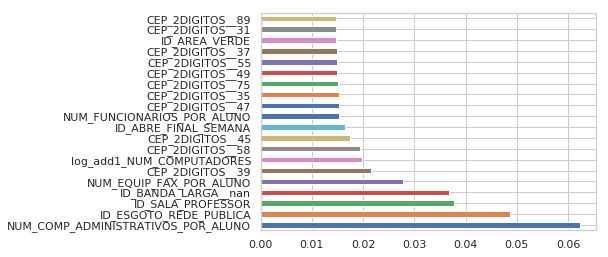

In [354]:
pd.Series(modelo_boost.feature_importances_, index=dfX.columns).nlargest(20).plot(kind='barh')

### Para o modelo atual (GradientBoostingRegressor), as variáveis de maior importância são:

In [355]:
pd.Series(modelo_boost.feature_importances_, index=dfX.columns).nlargest(10)

NUM_COMP_ADMINISTRATIVOS_POR_ALUNO    0.062261
ID_ESGOTO_REDE_PUBLICA                0.048613
ID_SALA_PROFESSOR                     0.037699
ID_BANDA_LARGA__nan                   0.036713
NUM_EQUIP_FAX_POR_ALUNO               0.027714
CEP_2DIGITOS__39                      0.021550
log_add1_NUM_COMPUTADORES             0.019749
CEP_2DIGITOS__58                      0.019442
CEP_2DIGITOS__45                      0.017370
ID_ABRE_FINAL_SEMANA                  0.016558
dtype: float64

In [402]:
registrar_obs(""" Verificado que para o modelo GradientBoostingRegressor, as variáveis de maior importância foram:
NUM_COMP_ADMINISTRATIVOS_POR_ALUNO    0.062261
ID_ESGOTO_REDE_PUBLICA                0.048613
ID_SALA_PROFESSOR                     0.037699
ID_BANDA_LARGA__nan                   0.036713
NUM_EQUIP_FAX_POR_ALUNO               0.027714
CEP_2DIGITOS__39                      0.021550
log_add1_NUM_COMPUTADORES             0.019749
CEP_2DIGITOS__58                      0.019442
CEP_2DIGITOS__45                      0.017370
ID_ABRE_FINAL_SEMANA                  0.016558
""")
        

### Boosting o algoritmo Ridge com Adaboost

In [367]:
param_dist = {
 'n_estimators': [50, 100],
 'learning_rate' : [0.5,1],
 'loss' : ['linear', 'square', 'exponential']
 }

In [397]:
modelo_boost=ensemble.AdaBoostRegressor(random_state=vrandom_state, loss= 'linear', base_estimator= linear_model.Ridge(alpha=.5), learning_rate= 1, n_estimators= 5)

In [398]:
# Instantiate the grid search model
grid_search = GridSearchCV(modelo_boost, param_grid = param_dist,
                          cv = 5, n_jobs = -1, verbose = 1, scoring='neg_mean_squared_error')

In [399]:
%%time
gs_results = grid_search.fit(X, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.9min finished


CPU times: user 42.5 s, sys: 1min 53s, total: 2min 36s
Wall time: 5min 7s


In [400]:
grid_search.best_params_

{'learning_rate': 0.5, 'loss': 'linear', 'n_estimators': 50}

In [401]:
grid_search.best_score_

-1.2109276314085438

In [403]:
param_dist = {
 'n_estimators': [3, 5, 10, 20],
 'learning_rate' : [0.5,0.1],
 'loss' : ['linear', 'square']
 }

In [404]:
grid_search = GridSearchCV(ensemble.AdaBoostRegressor(base_estimator=modelo, random_state=vrandom_state), param_grid=param_dist, cv=kf, n_jobs=-1)

In [405]:
modelo_boost=ensemble.AdaBoostRegressor(random_state=vrandom_state, loss= 'linear', base_estimator= linear_model.Ridge(alpha=.5), learning_rate= 1, n_estimators= 5)

In [406]:
# Instantiate the grid search model
grid_search = GridSearchCV(modelo_boost, param_grid = param_dist,
                          cv = 5, n_jobs = -1, verbose = 1, scoring='neg_mean_squared_error')

In [407]:
%%time
gs_results = grid_search.fit(X, y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.8min finished


CPU times: user 16.9 s, sys: 9.24 s, total: 26.1 s
Wall time: 1min 47s


In [408]:
grid_search.best_params_

{'learning_rate': 0.1, 'loss': 'linear', 'n_estimators': 3}

In [409]:
grid_search.best_score_

-1.064777981173105

In [410]:
param_dist = {
 'n_estimators': [1, 2, 3, 5, 10, 20],
 'learning_rate' : [0.1, 0.01, 0.005],
 'loss' : ['linear']
 }

In [411]:
# Instantiate the grid search model
grid_search = GridSearchCV(modelo_boost, param_grid = param_dist,
                          cv = 5, n_jobs = -1, verbose = 1, scoring='neg_mean_squared_error')

In [412]:
%%time
gs_results = grid_search.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.6min finished


CPU times: user 17.5 s, sys: 5.44 s, total: 22.9 s
Wall time: 1min 35s


In [413]:
grid_search.best_params_

{'learning_rate': 0.1, 'loss': 'linear', 'n_estimators': 2}

In [414]:
grid_search.best_score_

-1.0612962523594593

In [415]:
modelo_boost.set_params(**grid_search.best_params_)

AdaBoostRegressor(base_estimator=Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
         learning_rate=0.1, loss='linear', n_estimators=2, random_state=42)

In [416]:
df_avaliacao = regredir(df_avaliacao, modelo_boost, "Base completa; skf_k5_t15%; adaboost sobre ridge", X, y, kf,  True)

4.689 ['sklearn.ensemble.weight_boosting.AdaBoostRegressor', '-0.596146620960426', '-0.4894540696502087', '-0.592883354634684', '-0.48876850866876664']


In [417]:
registrar_obs("Experimentado (skf_k5_t15%) algoritmo de boosting AdaBoosting (gridsearch encontrou: n_estimators=2, lr=0.1, loss=linear)  sobre o ridge. O resultado piorou um pouco: de 0.5941 para 0.5961")
        

In [502]:
salva_ambiente()

## Stacking com os 3 algoritmos com menor erro médio

In [ ]:
# dicas em http://ml-ensemble.com/info/tutorials/start.html#ensemble-guide

from sklearn.metrics import accuracy_score,mean_absolute_error

In [ ]:
from mlens.ensemble import SuperLearner

In [486]:
## Stacking com os 3 algoritmos com maior acurácia (evolução futura)



# --- Build ---
# Passing a scoring function will create cv scores during fitting
# the scorer should be a simple function accepting to vectors and returning a scalar
ensemble = SuperLearner(scorer=mean_absolute_error, random_state=vrandom_state, verbose=2)

In [487]:
ensemble.add([linear_model.Ridge(alpha=0.5,random_state=vrandom_state),linear_model.BayesianRidge()])


SuperLearner(array_check=None, backend=None, folds=2,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=7270, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_ex...1923620>)],
   n_jobs=-1, name='group-6', raise_on_exception=True, transformers=[])],
   verbose=1)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=42, sample_size=20,
       scorer=<function mean_absolute_error at 0x7f5d11923620>,
       shuffle=False, verbose=2)

In [488]:
# Attach the final meta estimator
ensemble.add_meta(linear_model.Ridge(alpha=0.5,random_state=vrandom_state))

SuperLearner(array_check=None, backend=None, folds=2,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=7270, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_ex...1923620>)],
   n_jobs=-1, name='group-7', raise_on_exception=True, transformers=[])],
   verbose=1)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=42, sample_size=20,
       scorer=<function mean_absolute_error at 0x7f5d11923620>,
       shuffle=False, verbose=2)

In [489]:
%%time
# --- Use ---

# Fit ensemble
ensemble.fit(X_train, y_train)


Fitting 2 layers
Processing layer-1             done | 00:00:01
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:02
CPU times: user 12.1 s, sys: 35.1 s, total: 47.3 s
Wall time: 2.17 s


SuperLearner(array_check=None, backend=None, folds=2,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=7270, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_ex...1923620>)],
   n_jobs=-1, name='group-7', raise_on_exception=True, transformers=[])],
   verbose=1)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=42, sample_size=20,
       scorer=<function mean_absolute_error at 0x7f5d11923620>,
       shuffle=False, verbose=2)

In [490]:
preds = ensemble.predict(X_train)


Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:00


In [492]:
# Erro no treinamento
mean_absolute_error(y_train, preds)

0.5913942480140824

In [493]:
preds = ensemble.predict(X_test)


Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:00


In [494]:
# Erro no teste
mean_absolute_error(y_test, preds)

0.5931902578149242

### Experimentando stacking com mlxtend

In [465]:
from mlxtend.regressor import StackingRegressor

In [466]:
from sklearn.model_selection import train_test_split

In [467]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=vrandom_state)

In [468]:
X_test.shape, y_test.shape

((5816, 211), (5816,))

In [480]:
X_train.shape, y_train.shape

((32951, 211), (32951,))

In [470]:
stregr = StackingRegressor(regressors=[linear_model.Ridge(alpha=0.5,random_state=vrandom_state),linear_model.BayesianRidge()], 
                           meta_regressor=linear_model.Ridge(alpha=0.5,random_state=vrandom_state))

In [471]:
# Training the stacking classifier
stregr.fit(X_train, y_train)

StackingRegressor(meta_regressor=Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001),
         refit=True,
         regressors=[Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001), BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)],
         store_train_meta_features=False, use_features_in_secondary=False,
         verbose=0)

In [496]:
preds = stregr.predict(X_train)

In [498]:
# Erro no treinamento
mean_absolute_error(y_train, preds)

0.590935317730372

In [499]:
preds = stregr.predict(X_test)

In [500]:
# Erro no teste
mean_absolute_error(y_test, preds)

0.5932414804673933

### Visualizando o erro na base de teste

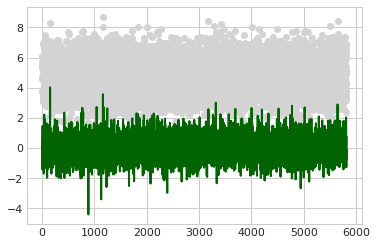

In [501]:
with plt.style.context(('seaborn-whitegrid')):
    plt.scatter(range(len(y_test)), y_test , c='lightgray')
    plt.plot(range(len(y_test)),  y_test - preds, c='darkgreen', lw=2)
plt.show()

## Calculando os stackers no kf

In [503]:
stregr = StackingRegressor(regressors=[linear_model.Ridge(alpha=0.5,random_state=vrandom_state),linear_model.BayesianRidge()], 
                           meta_regressor=linear_model.Ridge(alpha=0.5,random_state=vrandom_state))

In [504]:
df_avaliacao = regredir(df_avaliacao, stregr, "Base completa; skf_k5_t15%; stacking com mlxtend", X, y, kf,  True)

7.612 ['mlxtend.regressor.stacking_regression.StackingRegressor', '-0.5941665839358002', '-0.4864052713715605', '-0.5909401969584239', '-0.48624059199427816']


In [505]:
ensemble = SuperLearner(scorer=mean_absolute_error, random_state=vrandom_state, verbose=2)

In [506]:
ensemble.add([linear_model.Ridge(alpha=0.5,random_state=vrandom_state),linear_model.BayesianRidge()])


SuperLearner(array_check=None, backend=None, folds=2,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=7270, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_ex...1923620>)],
   n_jobs=-1, name='group-8', raise_on_exception=True, transformers=[])],
   verbose=1)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=42, sample_size=20,
       scorer=<function mean_absolute_error at 0x7f5d11923620>,
       shuffle=False, verbose=2)

In [507]:
# Attach the final meta estimator
ensemble.add_meta(linear_model.Ridge(alpha=0.5,random_state=vrandom_state))

SuperLearner(array_check=None, backend=None, folds=2,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=7270, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_ex...1923620>)],
   n_jobs=-1, name='group-9', raise_on_exception=True, transformers=[])],
   verbose=1)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=42, sample_size=20,
       scorer=<function mean_absolute_error at 0x7f5d11923620>,
       shuffle=False, verbose=2)

In [508]:
df_avaliacao = regredir(df_avaliacao, ensemble, "Base completa; skf_k5_t15%; stacking com library mlens", X, y, kf,  True)


Fitting 2 layers

Fitting 2 layers

Fitting 2 layers

Fitting 2 layers

Fitting 2 layers
Processing layer-1             done | 00:00:07
Processing layer-2             done | 00:00:00
Processing layer-1             done | 00:00:07
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:08

Predicting 2 layers
Processing layer-1             done | 00:00:08
Processing layer-2             done | 00:00:00
Processing layer-1             done | 00:00:07
Processing layer-2             done | 00:00:00
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:09

Predicting 2 layers
Processing layer-1             done | 00:00:08
Processing layer-2             done | 00:00:00
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:09

Predicting 2 layers
Fit complete                        | 00:00:08



In [509]:
registrar_obs("Experimentado (skf_k5_t15%) algoritmos de stacking usando libraries mlens e mlxtend. O resultado foi equivalente ao do Ridge alcançando antes: 0.5941")
        

# Finalizando

In [512]:
lista_obs.append("Finazando, o menor erro absoluto médio alcançado foi com o Ridge(alpha=0.5) de 0.5941 com R2 de 59%.")
        

In [513]:
salva_ambiente()

# Aprendizados registrados

In [514]:
imprime_lista_obs()

 
Lista de observações sobre a modelagem efetuada
 
Iremos comparar os modelos a partir do resultado na base de teste medido pela métrica neg_mean_absolute_error_mean (quanto menor em valor absoluto, melhor). Mas registraremos também r2 e neg_mean_absolute_error_median
 
O grid search no adaboost variando principalmente o base_algorithm rodou a noite toda e não passou do primeiro modelo: KNeighborsRegressor. Iremos tratar do boosting ao final em cima do algoritmo que obtiver melhor resultado
 
Selecionamos 2 modelos que conseguiram melhor r2 (0.59) e menor erro médio (0.59) em teste e são rápidos: sklearn.linear_model.bayes.BayesianRidge  e sklearn.linear_model.ridge.Ridge
 
Executado standscaler() não só nos 2 algoritmos selecionados pois não havia retirado os demais da lista
 
No contexto experimentado, a redução de escala não se mostrou favorável para os algoritmos selecionados (resultado semelhante ao anterior): Ridge (0.5948 -> 0.5952) BayesianRidge (0.5948->0.5953)
 
Para o algor

# Execuções registradas

In [510]:
df_avaliacao.shape

(83, 21)

In [511]:
# Log com algumas execuções efetuadas
df_avaliacao



obs tamanho  \
0                                       Amostra 10000   10000   
1                                       Amostra 10000   10000   
2                                       Amostra 10000   10000   
3                                       Amostra 10000   10000   
4   Base completa; Regressão experimental - primei...   38767   
5   Base completa; Regressão experimental - primei...   38767   
6   Base completa; Regressão experimental - primei...   38767   
7   Base completa; Regressão experimental - primei...   38767   
8   Base completa; Regressão experimental - primei...   38767   
9   Base completa; Regressão experimental - primei...   38767   
10  Base completa; Regressão experimental - primei...   38767   
11  Base completa; Regressão experimental - primei...   38767   
12  Base completa; Regressão experimental - primei...   38767   
13  Base completa; Regressão experimental - primei...   38767   
14  Base completa; Regressão experimental - primei...   38767   
15  Base completa; Regressão experimental - primei...   38767   
16  Base completa; Regressão experimental - primei...   38767   
17  Base completa; Regressão experimental - primei...   38767   
18  Base completa; AdaBoost. Parâmetros{'base_esti...   38767   
19  Base completa; AdaBoost. Parâmetros{'base_esti...   38767   
20  Base completa; AdaBoost. Parâmetros{'base_esti...   38767   
21                    Base completa; StandardScaler()   38767   
22                    Base completa; StandardScaler()   38767   
23                    Base completa; StandardScaler()   38767   
24                    Base completa; StandardScaler()   38767   
25                    Base completa; StandardScaler()   38767   
26                    Base completa; StandardScaler()   38767   
27                    Base completa; StandardScaler()   38767   
28                    Base completa; StandardScaler()   38767   
29                    Base completa; StandardScaler()   38767   
..                                                ...     ...   
53  Base completa; X com 90 dimensões reduzidas po...   38767   
54  Base completa; X com 90 dimensões reduzidas po...   38767   
55  Base completa; X com 100 dimensões reduzidas p...   38767   
56  Base completa; X com 100 dimensões reduzidas p...   38767   
57  Base completa; X com 110 dimensões reduzidas p...   38767   
58  Base completa; X com 110 dimensões reduzidas p...   38767   
59  Base completa; X com 120 dimensões reduzidas p...   38767   
60  Base completa; X com 120 dimensões reduzidas p...   38767   
61  Base completa; X com 130 dimensões reduzidas p...   38767   
62  Base completa; X com 130 dimensões reduzidas p...   38767   
63  Base completa; X com 140 dimensões reduzidas p...   38767   
64  Base completa; X com 140 dimensões reduzidas p...   38767   
65  Base completa; retirando 582 outliers (0,015%)...   38185   
66  Base completa; retirando 582 outliers (0,015%)...   38185   
67  Base completa; aumentando kfold de 5 para 10 -...   38767   
68  Base completa; aumentando kfold de 5 para 10 -...   38767   
69        Base completa; kfold 10; sem colunas de CEP   38767   
70        Base completa; kfold 10; sem colunas de CEP   38767   
71  Base completa; kfold 10; sem colunas de CEP, d...   38767   
72  Base completa; kfold 10; sem colunas de CEP, d...   38767   
73          Base completa; shufflekfold 5 (teste=15%)   38767   
74          Base completa; shufflekfold 5 (teste=15%)   38767   
75  Base completa; shuffle_kf (5, 15%); usando par...   38767   
76  Base completa; shuffle_kf (5, 15%); usando par...   38767   
77  Base completa; shuffle_kf (5, 15%); usando par...   38767   
78  Base completa; shuffle_kf (5, 15%); usando par...   38767   
79  Base completa; shuffle_kf (5, 15%); usando par...   38767   
80   Base completa; skf_k5_t15%; adaboost sobre ridge   38767   
81   Base completa; skf_k5_t15%; stacking com mlxtend   38767   
82  Base completa; skf_k5_t15%; stacking com libra...   38767   

                   

Pelo gráfico, percebe-se uma gradação do valor do ideb (maior na parte de trás da figura) - o que pode ser considerado um ponto favorável para a regressão!